# Extract one Object from Light Curves in single band at LSSTComCamSim

- author Sylvie Dagoret-Campagne (from Lauren macArthur)
- creation date 2024-06-03
- last update 2024-06-05

w_2024_16
  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 


https://tigress-web.princeton.edu/~lkelvin/pipelines/current/drp_pipe/LSSTComCamSim/nightly-validation-ops-rehearsal-3/

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/


In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
#( see https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas )
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

In [2]:
from collections import OrderedDict

In [3]:
#xx-small
#x-small
#small
#medium
#large
#x-large
#xx-large

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [4]:
from shapely.geometry import Point as shapelyPoint
from shapely.geometry.polygon import Polygon as shapelyPolygon

In [5]:
def is_in_polygon(x,y,ll,lr,ur,ul):
    point = shapelyPoint(x, y)
    polygon = shapelyPolygon([ll, lr, ur, ul])
    return polygon.contains(point)

In [6]:
saveDir = "./"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [7]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux = 100

In [8]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collectionn = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
#collections = [collection1,collection2,collection3]
collections = [collection2]
collection = collection2
collectionStr = collectionn.replace("/", "_")
instrument = 'LSSTComCamSim'
skymapName = "ops_rehersal_prep_2k_v1"
where_clause = "instrument = \'" + instrument+ "\'"
#3533 : No matching visitId
#tract = 2494
#tract = 7445
tract = 9880
band = "g"
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

#Aperture flux in instrumental
calibFluxStr = "apFlux_12_0_instFlux"
calibFluxErrStr = "apFlux_12_0_instFluxErr"
calibFluxMagStr = "apFlux_12_0_instMag"
calibFluxMagErrStr = "apFlux_12_0_instMagErr"

#Aperture flux in instrumental
calibFluxStr2 = "apFlux_17_0_instFlux"
calibFluxErrStr2 = "apFlux_17_0_instFluxErr"
calibFluxMagStr2 = "apFlux_17_0_instMag"
calibFluxMagErrStr2 = "apFlux_17_0_instMagErr"

#Aperture flux calibrated calibrated in AB
calibFluxCalStr = "apFlux_12_0_calFlux"
calibFluxCalErrStr = "apFlux_12_0_calFluxErr"
calibFluxCalMagStr = "apFlux_12_0_calMag"
calibFluxCalMagErrStr = "apFlux_12_0_calMagErr"


#Aperture flux calibrated calibrated in AB
calibFluxCalStr2 = "apFlux_17_0_calFlux"
calibFluxCalErrStr2 = "apFlux_17_0_calFluxErr"
calibFluxCalMagStr2 = "apFlux_17_0_calMag"
calibFluxCalMagErrStr2 = "apFlux_17_0_calMagErr"




file_output_selectedsources = f"lightcurves-dmrehearsal2024_04_03_tract{tract}.csv"
fullname_file_output_selectedsources = os.path.join(saveDir,file_output_selectedsources)

### object source files

In [9]:
output_objects_file = f"objectTable-t{tract}-b{band}-{collectionStr}.csv"
output_objects_file_truncated = f"objectTable-t{tract}-b{band}"
print(output_objects_file)

objectTable-t9880-bg-LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612.csv


In [10]:
#file_selected_visits = "../Visits/ccdVisittractpatch_LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612.csv"

In [11]:
#df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)
#my_selectedvisits = list(df_myselectedvisits.index)

In [12]:
#df_myselectedvisits

In [13]:
# Testing on an HSC RC2 run
# butlerRoot = "/repo/main"
# collection = "HSC/runs/RC2/w_2024_06/DM-42797"

# collectionStr = collection.replace("/", "_")
# instrument = "HSC"
# skymapName = "hsc_rings_v1"
# band = "i"
# tract = 9813

# calibFluxStr = "apFlux_12_0_instFlux"

In [14]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collection = {}".format(collection))

camera_name = LSSTComCamSim
collection = LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612


### load isolated_star_sources

In [15]:
# Try to get the Schema
all_tracts = []
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= where_clause)
for i, ref in enumerate(datasetRefs):
    print(i,ref.dataId)
    all_tracts.append(ref.dataId["tract"])
    #butler_data = butler.get(ref)

all_tracts = sorted(all_tracts)
print("all tracts : ", all_tracts)

#if not isinstance(butler_data, pd.core.frame.DataFrame):
#    print(butler_data.getSchema())

0 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494}
1 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495}
2 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2661}
3 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2662}
4 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3200}
5 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3345}
6 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3346}
7 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3533}
8 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3534}
9 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 6914}
10 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 6915}
11 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 7148}
12 {instrument: 'LSSTComCamSim', skyma

## isolated_star_sources

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [16]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [17]:
isolatedStarSourcesFull.head()

index             sourceId          visit  detector          ra       dec  \
74  14540  3065474140573008424  7024040300501         4  250.060690  2.095690   
75  18971  3065474141650945252  7024040300502         5  250.060693  2.095691   
76  15431  3065474142720493042  7024040300503         4  250.060692  2.095695   
77  17773  3065474143798428467  7024040300504         5  250.060683  2.095697   
78   8193  3065474144859588223  7024040300505         2  250.060682  2.095686   

   physical_filter band  apFlux_12_0_instFlux  apFlux_12_0_instFluxErr  \
74            g_01    g           7619.273926               365.131897   
75            g_01    g           7704.239258               397.332520   
76            g_01    g           6461.439453               353.792328   
77            g_01    g           7489.091797               430.034271   
78            g_01    g           6956.658691               363.972534   

              x            y      xErr      yErr  apFlux_17_0_instFlux  \
74  3422.957313   838.255810  0.072881  0.068851           7566.186455   
75   453.595942  1938.075083  0.079810  0.082730           7688.574922   
76  2805.750755  2269.772375  0.077034  0.066828           6320.241027   
77  1758.004658  1367.314225  0.094122  0.089072           7212.383802   
78   259.036811  2570.822478  0.079855  0.073634           7064.879179   

    apFlux_17_0_instFluxErr  apFlux_17_0_flag  localBackground_instFlux  \
74               516.024550             False                 -1.032511   
75               563.608859             False                 -0.145923   
76               502.121465             False                 -0.146530   
77               609.851258             False                 -0.916650   
78               514.736107             False                 -0.030645   

    localBackground_flag       ixx       iyy       ixy  source_row  obj_index  
74                 False  4.217578  4.121072 -0.369261       14540          0  
75                 False  4.086452  4.752029 -0.101619       18971          0  
76                 False  4.663101  3.911520 -0.052711       15431          0  
77                 False  4.811242  4.753206 -0.132956       17773          0  
78                 False  4.560931  4.261185 -0.385114        8193          0

In [18]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_12_0_instFlux',
       'apFlux_12_0_instFluxErr', 'x', 'y', 'xErr', 'yErr',
       'apFlux_17_0_instFlux', 'apFlux_17_0_instFluxErr', 'apFlux_17_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'ixx', 'iyy', 'ixy',
       'source_row', 'obj_index'],
      dtype='object')

## Select the visits in the preselected list

I add here my filter to select the visits I want to focus on from file_selected_visits = "../data/202402/SelectedVisits_fall2023_tract_3864.csv"
It include all bands

In [19]:
#def SelectByVisit(row):
#    if row["visit"] in my_selectedvisits:
#        return True
#    else:
#        return False

In [20]:
#isolatedStarSourcesFull["flag"] = isolatedStarSourcesFull.apply(SelectByVisit,axis=1,raw=False)

In [21]:
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["flag"]]
#isolatedStarSourcesFull.drop("flag",axis=1,inplace=True)

In [22]:
isolatedStarSourcesFull

index             sourceId          visit  detector          ra  \
74      14540  3065474140573008424  7024040300501         4  250.060690   
75      18971  3065474141650945252  7024040300502         5  250.060693   
76      15431  3065474142720493042  7024040300503         4  250.060692   
77      17773  3065474143798428467  7024040300504         5  250.060683   
78       8193  3065474144859588223  7024040300505         2  250.060682   
...       ...                  ...            ...       ...         ...   
775131   9399  3065474273708606842  7024040300625         2  250.026089   
775132  28700  3065474143811012641  7024040300504         8  250.312370   
775133  29266  3065474157769656442  7024040300517         8  250.550183   
775134  29116  3065474157769656292  7024040300517         8  250.482685   
775135  16498  3065474148093394956  7024040300508         5  249.945582   

             dec physical_filter band  apFlux_12_0_instFlux  \
74      2.095690            g_01    g           7619.273926   
75      2.095691            g_01    g           7704.239258   
76      2.095695            g_01    g           6461.439453   
77      2.095697            g_01    g           7489.091797   
78      2.095686            g_01    g           6956.658691   
...          ...             ...  ...                   ...   
775131  2.418335            g_01    g           3984.312744   
775132  1.836745            g_01    g           4176.901367   
775133  1.945469            g_01    g         800017.187500   
775134  1.872596            g_01    g         124029.570312   
775135  2.204232            g_01    g           4090.202881   

        apFlux_12_0_instFluxErr            x            y      xErr      yErr  \
74                   365.131897  3422.957313   838.255810  0.072881  0.068851   
75                   397.332520   453.595942  1938.075083  0.079810  0.082730   
76                   353.792328  2805.750755  2269.772375  0.077034  0.066828   
77                   430.034271  1758.004658  1367.314225  0.094122  0.089072   
78                   363.972534   259.036811  2570.822478  0.079855  0.073634   
...                         ...          ...          ...       ...       ...   
775131               391.048798  2035.575992  1818.560504  0.120705  0.129306   
775132               412.696472  2255.960068  3615.972391  0.188566  0.196696   
775133               803.035706  2737.799120  3726.835188  0.003885  0.003472   
775134               486.225403   966.636234  3497.570017  0.010814  0.009351   
775135               407.567932  2898.652194    32.796596  0.253268  0.206434   

        apFlux_17_0_instFlux  apFlux_17_0_instFluxErr  apFlux_17_0_flag  \
74               7566.186455               516.024550             False   
75               7688.574922               563.608859             False   
76               6320.241027               502.121465             False   
77               7212.383802               609.851258             False   
78               7064.879179               514.736107             False   
...                      ...                      ...               ...   
775131           3789.695704               556.783925             False   
775132           3529.054085               583.728068             False   
775133         808386.480869               903.857699             False   
775134         126195.380045               639.065152             False   
775135           4385.497837               579.836477             False   

        localBackground_instFlux  localBackground_flag       ixx       iyy  \
74                     -1.032511                 False  4.217578  4.121072   
75                     -0.145923                 False  4.086452  4.752029   
76                     -0.146530                 False  4.663101  3.911520   
77                     -0.916650                 False  4.811242  4.753206   
78                     -0.030645                 False  4.560931  4.261185   
...     

In [23]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

Empty DataFrame
Columns: [index, sourceId, visit, detector, ra, dec, physical_filter, band, apFlux_12_0_instFlux, apFlux_12_0_instFluxErr, x, y, xErr, yErr, apFlux_17_0_instFlux, apFlux_17_0_instFluxErr, apFlux_17_0_flag, localBackground_instFlux, localBackground_flag, ixx, iyy, ixy, source_row, obj_index]
Index: []

In [24]:
print("calibFluxStr = {}, minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_12_0_instFlux, minSnCalibFlux = 100, minNumMatches = 3


## Select a number of visits with enough good sources in the required band

- extract the list of known objects

In [25]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

# Select a number of visits according quality criteria
visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched souces from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_12_0_instFlux > 100 (leaving N=91167 matched souces from original 233210)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 5527 objects from 16725).


In [26]:
sorted_visitList = sorted(visitList)
sorted_visitList[:20] 

[7024040300501,
 7024040300502,
 7024040300503,
 7024040300504,
 7024040300505,
 7024040300506,
 7024040300507,
 7024040300508,
 7024040300509,
 7024040300510,
 7024040300511,
 7024040300512,
 7024040300513,
 7024040300514,
 7024040300515,
 7024040300516,
 7024040300517,
 7024040300518,
 7024040300519,
 7024040300520]

In [27]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [28]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [29]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


## sourceTable_visit

This is the main output of FGCM calibration which has selected a number of sources. These sources were originally selected from isolated sources.

In [30]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

In [31]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

# loop over all selected visit
for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {}".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit exsistence check: {}".format(len(objIndexList)))
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

Number of objects with >=3 matches before sourceTable_visit exsistence check: 5527
Number of objects with >=3 matches after sourceTable_visit exsistence check: 5527


In [32]:
visitsToRemove 

[]

## Will start to work on dataJoined which associate selected "isolated_star_sources" in the selected band and visits the good calibration in "sourceTable_visit"

### add my info from CCD Visit Table

- CCD visit table is a pre-FGCM calibration
- it provides airmass and initial zero-point

In [33]:
# need also. ["zeroPoint","airmass"]

In [34]:
# Collect useful columns from ccdVisitTable
ccdVisitTable = butler.get("ccdVisitTable")
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + 
                                    ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)
psfSigmaDict = {}
skyBgDict = {}
skyNoiseDict = {}
expTimeDict = {}
expMidptMjdDict = {}
medianEDict = {}
psfStarScaledDeltaSizeScatterDict = {}
astromOffsetStdDict = {}
psfTraceRadiusDeltaDict = {}
zeroPointDict = {}
airmassDict = {}
seeingDict = {}
npsfStarsDict = {}
psfSigmaDict = {}

# for visit in ccdVisitTable["visitId"].values:
#     if visit in visitList:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
        skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
        skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
        expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
        expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
        medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
        psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
        astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
        psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
        zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
        airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
        seeingDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["seeing"].values[0]
        npsfStarsDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["nPsfStar"].values[0]
        psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
    else:
        raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))
        visitsCCDToRemove.append(visit) 
        psfSigmaDict[visit] = np.nan
        skyBgDict[visit] = np.nan
        skyNoiseDict[visit] = np.nan
        expTimeDict[visit] = np.nan
        expMidptMjdDict[visit] = np.nan
        medianEDict[visit] = np.nan
        psfStarScaledDeltaSizeScatterDict[visit] = np.nan
        astromOffsetStdDict[visit] = np.nan
        psfTraceRadiusDeltaDict[visit] = np.nan
        zeroPointDict[visit] = np.nan
        airmassDict[visit] = np.nan
        seeingDict[visit] = np.nan
        npsfStarsDict[visit] = np.nan
        psfSigmaDict[visit] = np.nan 

### Plot visits versus time

In [35]:
# Just to have a look at what's in the catalog:
ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[0]] 

visitId physical_filter band          ra        dec  \
ccdVisitId                                                                
730865860864  7024040300001            r_03    r  124.617999 -15.026212   

              zenithDistance  zeroPoint  psfSigma        skyBg  skyNoise  \
ccdVisitId                                                                 
730865860864       17.825243  31.258871  1.507056  1703.767822  34.47179   

              astromOffsetMean  astromOffsetStd  nPsfStar  \
ccdVisitId                                                  
730865860864          0.005423         0.003085       534   

              psfStarDeltaE1Median  psfStarDeltaE2Median  \
ccdVisitId                                                 
730865860864              0.000671              0.000063   

              psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  \
ccdVisitId                                                   
730865860864               0.010385               0.010232   

              psfStarDeltaSizeMedian  psfStarDeltaSizeScatter  \
ccdVisitId                                                      
730865860864               -0.001001                 0.009205   

              psfStarScaledDeltaSizeScatter  psfTraceRadiusDelta  \
ccdVisitId                                                         
730865860864                       0.006108             0.012708   

              maxDistToNearestPsf    effTime  effTimePsfSigmaScale  \
ccdVisitId                                                           
730865860864           343.330109  11.789084              1.127149   

              effTimeSkyBgScale  effTimeZeroPointScale       decl  detector  \
ccdVisitId                                                                    
730865860864           0.344765                1.01124 -15.026212         0   

               seeing  skyRotation                   expMidpt   expMidptMJD  \
ccdVisitId                                                                    
730865860864  0.71116   121.461718 2024-04-03 23:30:29.555496  60403.979509   

              expTime                   obsStart   obsStartMJD  darkTime  \
ccdVisitId                                                                 
730865860864     30.0 2024-04-03 23:30:14.555496  60403.979335   33.0576   

              xSize  ySize       llcra     llcdec       ulcra     ulcdec  \
ccdVisitId                                                                 
730865860864   4071   3999  124.458471 -15.063877  124.581823 -14.871498   

                   urcra     urcdec       lrcra     lrcdec   airmass   medianE  
ccdVisitId                                                                      
730865860864  124.777487 -14.988434  124.654231 -15.180921  1.050426  0.000674

In [36]:
ccdVisitTable_subset = ccdVisitTable[["visitId","band","zeroPoint","psfSigma","skyBg","skyNoise","seeing","expTime","expMidptMJD","obsStart","airmass","medianE","psfStarScaledDeltaSizeScatter",
                                      "astromOffsetStd","psfTraceRadiusDelta",
                                      "llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec"]]

In [37]:
ccdVisitTable_subset["removed"] = ccdVisitTable_subset["visitId"].apply(lambda x: True if x in visitsToRemove else False) 

In [38]:
ccdVisitTable_subset["nightObs"] = ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000 - 50000000, axis=1)
ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])

In [39]:
ccdVisitTable_subset_removed = ccdVisitTable_subset[ccdVisitTable_subset["removed"]] 

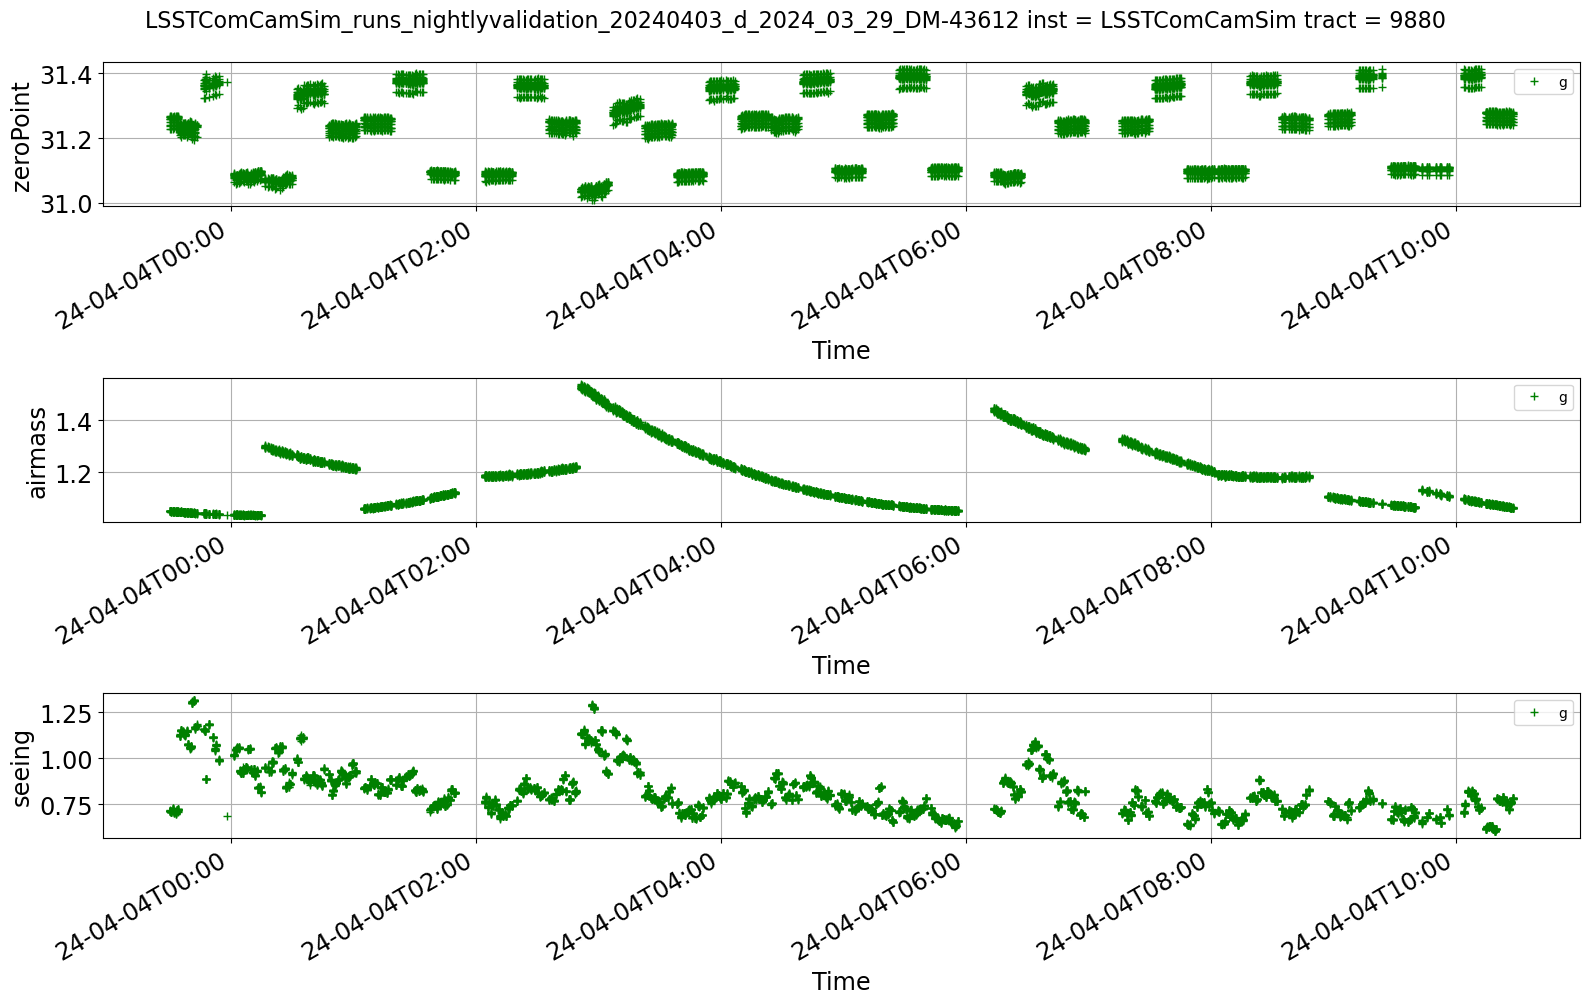

In [40]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")

fig,axs = plt.subplots(3,1,figsize=(16,10))
ax1,ax2,ax3 = axs
ccdVisitTable_subset.plot(x="Time",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label=band)
ax1.set_ylabel("zeroPoint")
ax1.xaxis.set_major_formatter(date_form)

ccdVisitTable_subset.plot(x="Time",y="airmass",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label=band)
ax2.set_ylabel("airmass")
ax2.xaxis.set_major_formatter(date_form)

ccdVisitTable_subset.plot(x="Time",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label=band)
ax3.set_ylabel("seeing")
ax3.xaxis.set_major_formatter(date_form)

plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()


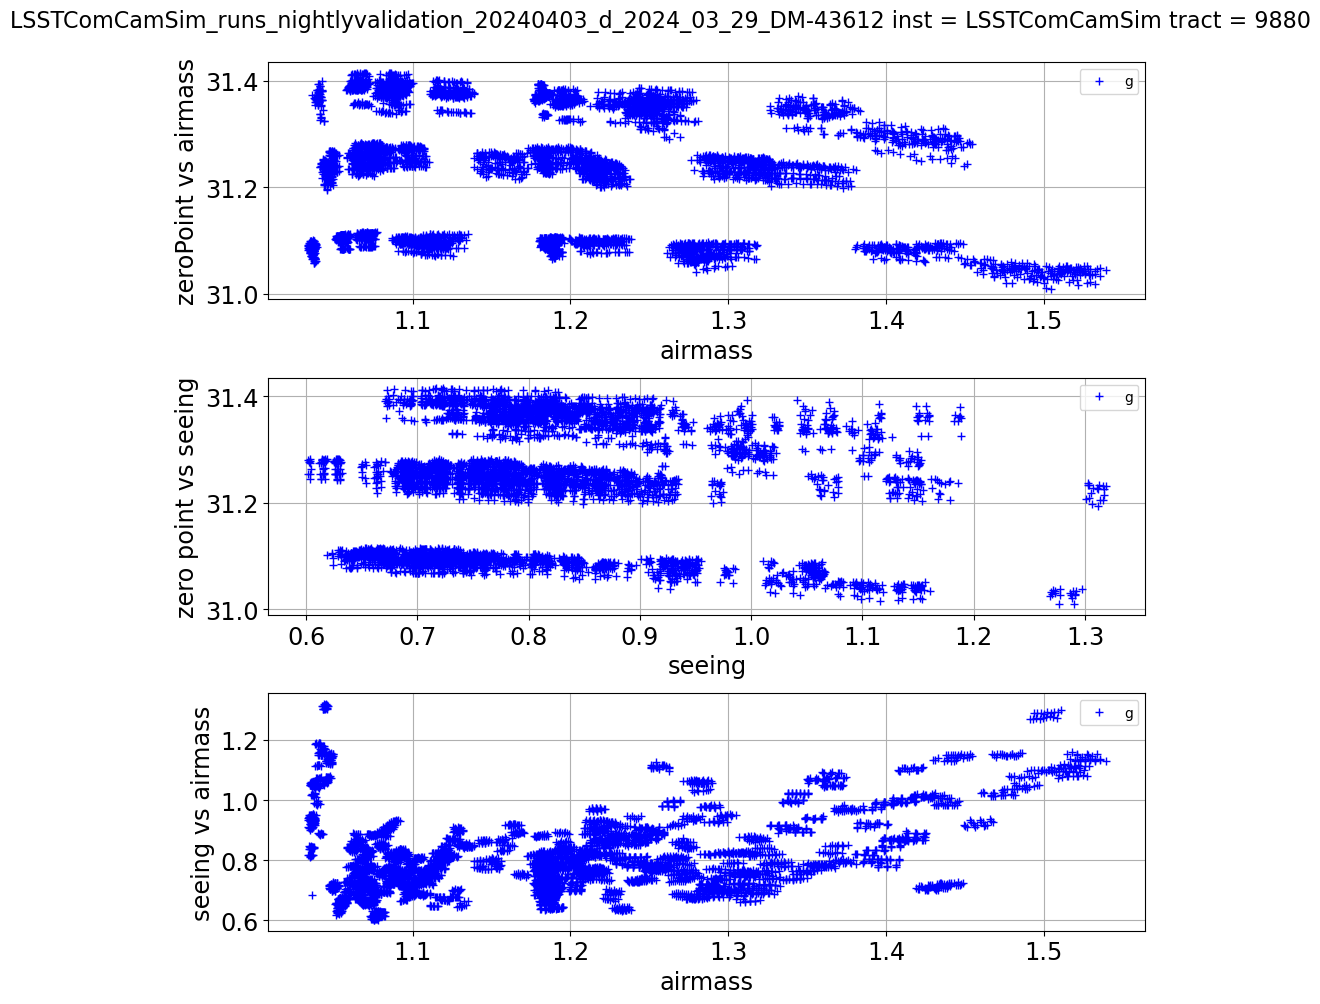

In [41]:
fig,axs = plt.subplots(3,1,figsize=(10,10))
ax1,ax2,ax3 = axs
ccdVisitTable_subset.plot(x="airmass",y="zeroPoint",marker='+',c="b",lw=0.0,ax=ax1,grid=True,label=band)
ax1.set_ylabel("zeroPoint vs airmass")

ccdVisitTable_subset.plot(x="seeing",y="zeroPoint",marker='+',c="b",lw=0.0,ax=ax2,grid=True,label=band)
ax2.set_ylabel("zero point vs seeing")

ccdVisitTable_subset.plot(x="airmass",y="seeing",marker='+',c="b",lw=0.0,ax=ax3,grid=True,label=band)
ax3.set_ylabel("seeing vs airmass")

plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

### Recalculate sources properties inside dataJoined before adding CCDVisit info

In [42]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_12_0_instFlux',
       'apFlux_12_0_instFluxErr', 'x', 'y', 'xErr', 'yErr',
       'apFlux_17_0_instFlux', 'apFlux_17_0_instFluxErr', 'apFlux_17_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'ixx', 'iyy', 'ixy',
       'source_row', 'obj_index'],
      dtype='object')

In [43]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)
# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.

dataJoined[calibFluxCalStr] = dataJoined[calibFluxStr]*dataJoined["localPhotoCalib"]
dataJoined[calibFluxCalErrStr] = dataJoined[calibFluxErrStr]*dataJoined["localPhotoCalib"]

dataJoined[calibFluxCalMagStr] = (dataJoined[calibFluxCalStr].values*u.nJy).to(u.ABmag).value
dataJoined[calibFluxCalMagErrStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxCalErrStr].values/dataJoined[calibFluxCalStr].values)

dataJoined[calibFluxCalStr2] = dataJoined[calibFluxStr2]*dataJoined["localPhotoCalib"]
dataJoined[calibFluxCalErrStr2] = dataJoined[calibFluxErrStr2]*dataJoined["localPhotoCalib"]

dataJoined[calibFluxCalMagStr2] = (dataJoined[calibFluxCalStr2].values*u.nJy).to(u.ABmag).value
dataJoined[calibFluxCalMagErrStr2] = 2.5/np.log(10.0)*(dataJoined[calibFluxCalErrStr2].values/dataJoined[calibFluxCalStr2].values)


# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfInstMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)


dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]

## dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
## dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
## dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
## dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
## dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
## dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
## dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
## dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
## dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)

# I add the airmass and zero-point I want to keep here
## dataJoined["zeroPoint"] = dataJoined.apply(lambda x: zeroPointDict[x["visit"]], axis=1)
## dataJoined["airmass"] = dataJoined.apply(lambda x: airmassDict[x["visit"]], axis=1)

matchedObjIdList = list(set(dataJoined["obj_index"]))

### Extract info from CCDVisit

In [44]:
# Example of apply function format  that does what we expect
# dataJoined[["ra","dec"]].apply(lambda x: pd.Series([x["ra"], x["dec"]], index=['ra_2', 'dec_2']), axis=1)

In [45]:
# Example of function calculating in which detector is the source
def findCCDVisitPerSource(x):
    """
    Find the CCD visit cooresponding to that source
    """
    visitId = x["visit"]
    ra0 = x["ra"]
    dec0 = x ["dec"]
    ccd_visit_table_forthatvisit = ccdVisitTable[ccdVisitTable.visitId == visitId]
    ccd_visit_table_forthatvisit["select"] =  ccd_visit_table_forthatvisit.apply(lambda x :  is_in_polygon(ra0,dec0,(x["llcra"],x["llcdec"]), (x["lrcra"],x["lrcdec"]), (x["urcra"],x["urcdec"]),(x["ulcra"],x["ulcdec"])),axis=1)
    ccd_visit_table_forthatvisit = ccd_visit_table_forthatvisit[ccd_visit_table_forthatvisit["select"]] 
    ccd_visit_table_forthatvisit["dra"] = ra0 - ccd_visit_table_forthatvisit["ra"] 
    ccd_visit_table_forthatvisit["ddec"] = dec0 - ccd_visit_table_forthatvisit["dec"] 
    ccd_visit_table_forthatvisit.reset_index(inplace=True)
    ccd_visit_table_forthatvisit.rename(columns = {'ccdVisitId':'ccd_ccdVisitId',"visitId": "ccd_visitId","band":"ccd_band","detector":"ccd_detector"}, inplace = True) 
    ccd_visit_table_forthatvisit.drop(columns = ["physical_filter","ra","dec","select"],inplace=True)
    
    assert len(ccd_visit_table_forthatvisit == 1)
    # Convert the dataframe into a pandas series
    # Do not do ccd_visit_table_forthatvisit.T
    ser =  ccd_visit_table_forthatvisit.iloc[0,:]
    ser.name = "ccd_visit_table_forthatvisit"
    return ser

### Extract the columns from the CCDVisitTable corresponding to each row of dataJoined

In [46]:
dataJoined_toadd = dataJoined.apply(findCCDVisitPerSource,axis=1)

In [47]:
dataJoined_toadd

ccd_ccdVisitId    ccd_visitId ccd_band  zenithDistance  zeroPoint  \
0        730866023936  7024040300638        g       32.109695  31.365871   
1        730866023936  7024040300638        g       32.109695  31.365871   
2        730866023936  7024040300638        g       32.109695  31.365871   
3        730866023936  7024040300638        g       32.109695  31.365871   
4        730866023936  7024040300638        g       32.109695  31.365871   
...               ...            ...      ...             ...        ...   
91162    730866023688  7024040300637        g       32.257236  31.337864   
91163    730866023688  7024040300637        g       32.257236  31.337864   
91164    730866023688  7024040300637        g       32.257236  31.337864   
91165    730866023688  7024040300637        g       32.257236  31.337864   
91166    730866023688  7024040300637        g       32.257236  31.337864   

       psfSigma       skyBg   skyNoise  astromOffsetMean  astromOffsetStd  \
0      1.699129  399.431366  20.061857          0.009552         0.005470   
1      1.699129  399.431366  20.061857          0.009552         0.005470   
2      1.699129  399.431366  20.061857          0.009552         0.005470   
3      1.699129  399.431366  20.061857          0.009552         0.005470   
4      1.699129  399.431366  20.061857          0.009552         0.005470   
...         ...         ...        ...               ...              ...   
91162  1.671923  389.393097  20.165636          0.011023         0.006702   
91163  1.671923  389.393097  20.165636          0.011023         0.006702   
91164  1.671923  389.393097  20.165636          0.011023         0.006702   
91165  1.671923  389.393097  20.165636          0.011023         0.006702   
91166  1.671923  389.393097  20.165636          0.011023         0.006702   

       nPsfStar  psfStarDeltaE1Median  psfStarDeltaE2Median  \
0           602             -0.000007              0.000045   
1           602             -0.000007              0.000045   
2           602             -0.000007              0.000045   
3           602             -0.000007              0.000045   
4           602             -0.000007              0.000045   
...         ...                   ...                   ...   
91162       638              0.000303             -0.000478   
91163       638              0.000303             -0.000478   
91164       638              0.000303             -0.000478   
91165       638              0.000303             -0.000478   
91166       638              0.000303             -0.000478   

       psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  psfStarDeltaSizeMedian  \
0                   0.011713               0.009454                0.001473   
1                   0.011713               0.009454                0.001473   
2                   0.011713               0.009454                0.001473   
3                   0.011713               0.009454                0.001473   
4                   0.011713               0.009454                0.001473   
...                      ...                    ...                     ...   
91162               0.012305               0.010900                0.000511   
91163               0.012305               0.010900                0.000511   
91164               0.012305               0.010900                0.000511   
91165               0.012305               0.010900                0.000511   
91166               0.012305               0.010900                0.000511   

       psfStarDeltaSizeScatter  psfStarScaledDeltaSizeScatter  \
0                     0.014495                       0.008511   
1                     0.014495                       0.008511   
2                     0.014495                       0.008511   
3                     0.014495                       0.008511   
4                     0.014495                       0.008511   
...                        ...                            ...   
91162   

In [48]:
dataJoined = dataJoined.join(dataJoined_toadd) 

In [49]:
#dataJoined.plot.scatter(x="detector",y="ccd_detector") 

In [50]:
#dataJoined.plot.scatter(x="visit",y="ccd_visitId") 

In [51]:
dataJoined[dataJoined.index == 0]

sourceId       psfFlux  psfFluxErr  psfFlux_flag  \
0  3065474287658860562  55090.875296  264.554493         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0        0.995434                0.0           0.0              True   

   deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  55836.237846       308.720742              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0         1.031786            0.000387                 False     17   

           visit  detector          ra       dec physical_filter band  \
0  7024040300638         0  249.586608  1.919988            g_01    g   

   apFlux_12_0_instFlux  apFlux_12_0_instFluxErr            x          y  \
0          54164.460938               472.363983  1466.279408  23.445362   

       xErr      yErr  apFlux_17_0_instFlux  apFlux_17_0_instFluxErr  \
0  0.014118  0.012696          54740.788134               650.744358   

   apFlux_17_0_flag  localBackground_instFlux  localBackground_flag       ixx  \
0             False                  0.266611                 False  3.102967   

        iyy       ixy  source_row  obj_index      psfSn     psfMag  psfMagErr  \
0  2.815937 -0.097192          17      16552  208.24018  19.547301   0.005214   

   apFlux_12_0_calFlux  apFlux_12_0_calFluxErr  apFlux_12_0_calMag  \
0         55886.137137              487.378585            19.53174   

   apFlux_12_0_calMagErr  apFlux_17_0_calFlux  apFlux_17_0_calFluxErr  \
0               0.009469         56480.783519              671.428974   

   apFlux_17_0_calMag  apFlux_17_0_calMagErr  psfInstMag  psfInstMagErr  \
0           19.520248               0.012907   19.581275       0.005214   

   psfGausFluxRatio  ccd_ccdVisitId    ccd_visitId ccd_band  zenithDistance  \
0          0.986651    730866023936  7024040300638        g       32.109695   

   zeroPoint  psfSigma       skyBg   skyNoise  astromOffsetMean  \
0  31.365871  1.699129  399.431366  20.061857          0.009552   

   astromOffsetStd  nPsfStar  psfStarDeltaE1Median  psfStarDeltaE2Median  \
0          0.00547       602             -0.000007              0.000045   

   psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  psfStarDeltaSizeMedian  \
0               0.011713               0.009454                0.001473   

   psfStarDeltaSizeScatter  psfStarScaledDeltaSizeScatter  \
0                 0.014495                       0.008511   

   psfTraceRadiusDelta  maxDistToNearestPsf    effTime  effTimePsfSigmaScale  \
0             0.012837           322.599701  21.291468              1.024717   

   effTimeSkyBgScale  effTimeZeroPointScale      decl  ccd_detector    seeing  \
0           0.701497               0.987312  1.915916             0  0.801279   

   skyRotation                   expMidpt   expMidptMJD  expTime  \
0   107.973281 2024-04-04 08:31:00.604501  60404.354868     30.0   

                    obsStart   obsStartMJD  darkTime  xSize  ySize  \
0 2024-04-04 08:30:45.604501  60404.354694   33.0526   4071   3999   

        llcra    llcdec       ulcra    ulcdec       urcra    urcdec  \
0  249.559991  1.842891  249.630384  2.058091  249.841897  1.988944   

        lrcra    lrcdec   airmass   medianE       dra      ddec  
0  249.771467  1.773741  1.180593  0.000045 -0.114321  0.004071

## The association between the independent sources is done through the object index 

- for plotting the repeatability

In [52]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
nSourcesCliAll = []
raSourcesCliAll = []
decSourcesCliAll = []

# in AB magnitude
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagMeanMagAll = []
psfMagMeanMagErrAll = []

psfMagStdMmagDict = OrderedDict()
psfMagMeanMagDict = OrderedDict()  # add the mean magnitude
psfMagDiffChiDfList = []

# aperture in ADU

ap12InstMagMeanMagAll = []
ap12InstMagMeanMagErrAll = []

ap17InstMagMeanMagAll = []
ap17InstMagMeanMagErrAll = []

psfSnAll = []

raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = OrderedDict()


# loop on objects
for objIndex in matchedObjIdList:
    # select sources corresponding to that object
    objData = dataJoined[dataJoined["obj_index"] == objIndex]

    # flux with psf
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]
    psfFluxes = objData['psfFlux']
    psfFluxesErr = objData['psfFluxErr']
    psfSn = psfFluxes/psfFluxesErr

    # average flux over all visits
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))
    nSourcesCli = len(clippedMeanMagArray)


    ap12InstMag =  -2.5*np.log10(objData["apFlux_12_0_instFlux"])
    clippedMeanAp12InstMagArray = scipy.stats.sigmaclip(ap12InstMag, low=3.0, high=3.0).clipped
    clippedMeanAp12InstMag = np.mean(clippedMeanAp12InstMagArray)
    clippedMeanAp12InstMagErr = np.std(clippedMeanAp12InstMagArray)/np.sqrt(len(clippedMeanAp12InstMagArray))
    

    ap17InstMag =  -2.5*np.log10(objData["apFlux_17_0_instFlux"])
    clippedMeanAp17InstMagArray = scipy.stats.sigmaclip(ap17InstMag, low=3.0, high=3.0).clipped
    clippedMeanAp17InstMag = np.mean(clippedMeanAp17InstMagArray)
    clippedMeanAp17InstMagErr = np.std(clippedMeanAp17InstMagArray)/np.sqrt(len(clippedMeanAp17InstMagArray))


    # Signal to Noise 
    clippedpsfSnArray = scipy.stats.sigmaclip(psfSn, low=3.0, high=3.0).clipped
    clippedpsfSnMean = np.mean(clippedpsfSnArray)

    # array of difference between flux an clipped mean average
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    # sigma arrays over the difference
    psfMagStdMmag = np.std(psfMagDiffMmag)
    # residuals array
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)


    #objData["psfMagDiffMmag"] = psfMagDiffMmag
    #objData["psfMagDiffChi"] = psfMagDiffChi
    objData.loc[:,"psfMagDiffMmag"] = psfMagDiffMmag
    objData.loc[:,"psfMagDiffChi"] = psfMagDiffChi
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000

    #objData["raDiffMas"] = raDiffMas
    objData.loc[:,"raDiffMas"] = raDiffMas
    
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000

    #objData["decDiffMas"] = decDiffMas
    objData.loc[:,"decDiffMas"] = decDiffMas
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    #objData["raCosDecDiffMas"] = raCosDecDiffMas
    objData.loc[:,"raCosDecDiffMas"] = raCosDecDiffMas

    # save for all sources of the object in list
    nSourcesCliAll.append(nSourcesCli)

    raSourcesCliAll.append(clippedMeanRa)
    decSourcesCliAll.append(clippedMeanDec)

    psfMagMeanMagAll.append(clippedMeanMag)
    psfMagMeanMagErrAll.append(clippedMeanMagErr)
    psfSnAll.append(clippedpsfSnMean) 
    
    
    # save for all sources of the object
    psfMagDiffMmagDfList.append(psfMagDiffMmag)
    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    #--

    ap12InstMagMeanMagAll.append(clippedMeanAp12InstMag)
    ap12InstMagMeanMagErrAll.append(clippedMeanAp12InstMagErr)

    ap17InstMagMeanMagAll.append(clippedMeanAp17InstMag)
    ap17InstMagMeanMagErrAll.append(clippedMeanAp17InstMagErr)

    #--
    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)

    # save in Dictionnaries
    psfMagStdMmagDict[objIndex] = psfMagStdMmag
    psfMagMeanMagDict[objIndex] = clippedMeanMag 
    
    objDataList[objIndex] = objData

# concatenate over all objects - all sources
psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)

# add this common properties to each source in dataJoined
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [53]:
dataJoined[dataJoined.index == 0]

sourceId       psfFlux  psfFluxErr  psfFlux_flag  \
0  3065474287658860562  55090.875296  264.554493         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0        0.995434                0.0           0.0              True   

   deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  55836.237846       308.720742              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0         1.031786            0.000387                 False     17   

           visit  detector          ra       dec physical_filter band  \
0  7024040300638         0  249.586608  1.919988            g_01    g   

   apFlux_12_0_instFlux  apFlux_12_0_instFluxErr            x          y  \
0          54164.460938               472.363983  1466.279408  23.445362   

       xErr      yErr  apFlux_17_0_instFlux  apFlux_17_0_instFluxErr  \
0  0.014118  0.012696          54740.788134               650.744358   

   apFlux_17_0_flag  localBackground_instFlux  localBackground_flag       ixx  \
0             False                  0.266611                 False  3.102967   

        iyy       ixy  source_row  obj_index      psfSn     psfMag  psfMagErr  \
0  2.815937 -0.097192          17      16552  208.24018  19.547301   0.005214   

   apFlux_12_0_calFlux  apFlux_12_0_calFluxErr  apFlux_12_0_calMag  \
0         55886.137137              487.378585            19.53174   

   apFlux_12_0_calMagErr  apFlux_17_0_calFlux  apFlux_17_0_calFluxErr  \
0               0.009469         56480.783519              671.428974   

   apFlux_17_0_calMag  apFlux_17_0_calMagErr  psfInstMag  psfInstMagErr  \
0           19.520248               0.012907   19.581275       0.005214   

   psfGausFluxRatio  ccd_ccdVisitId    ccd_visitId ccd_band  zenithDistance  \
0          0.986651    730866023936  7024040300638        g       32.109695   

   zeroPoint  psfSigma       skyBg   skyNoise  astromOffsetMean  \
0  31.365871  1.699129  399.431366  20.061857          0.009552   

   astromOffsetStd  nPsfStar  psfStarDeltaE1Median  psfStarDeltaE2Median  \
0          0.00547       602             -0.000007              0.000045   

   psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  psfStarDeltaSizeMedian  \
0               0.011713               0.009454                0.001473   

   psfStarDeltaSizeScatter  psfStarScaledDeltaSizeScatter  \
0                 0.014495                       0.008511   

   psfTraceRadiusDelta  maxDistToNearestPsf    effTime  effTimePsfSigmaScale  \
0             0.012837           322.599701  21.291468              1.024717   

   effTimeSkyBgScale  effTimeZeroPointScale      decl  ccd_detector    seeing  \
0           0.701497               0.987312  1.915916             0  0.801279   

   skyRotation                   expMidpt   expMidptMJD  expTime  \
0   107.973281 2024-04-04 08:31:00.604501  60404.354868     30.0   

                    obsStart   obsStartMJD  darkTime  xSize  ySize  \
0 2024-04-04 08:30:45.604501  60404.354694   33.0526   4071   3999   

        llcra    llcdec       ulcra    ulcdec       urcra    urcdec  \
0  249.559991  1.842891  249.630384  2.058091  249.841897  1.988944   

        lrcra    lrcdec   airmass   medianE       dra      ddec  \
0  249.771467  1.773741  1.180593  0.000045 -0.114321  0.004071   

   psfMagDiffMmag  psfMagDiffChi  raDiffMas  decDiffMas  raCosDecDiffMas  
0        8.155652       1.500235     1.4995   -1.102895         1.659622

In [54]:
#pd.set_option('display.max_rows', None)

In [55]:
#print(matchedObjIdList)

### Create a pandas dataframe from all objects

In [56]:
df_obj = pd.DataFrame()

In [57]:
df_obj["objindex"] = matchedObjIdList
df_obj["ra"] = raSourcesCliAll
df_obj["dec"] = decSourcesCliAll
df_obj["nSources"] = nSourcesCliAll
df_obj["psfSn"] = psfSnAll
df_obj["psfMag"] = psfMagMeanMagAll
df_obj["psfMagErr"] = psfMagMeanMagErrAll
df_obj["psfMagStdMmag"]  =   psfMagStdMmagAll
df_obj["ap12nstMeanMag"] = ap12InstMagMeanMagAll
df_obj["ap12InstMeanMagErr"] = ap12InstMagMeanMagErrAll
df_obj["ap17InstMeanMag"] = ap17InstMagMeanMagAll
df_obj["ap17InstMeanMagErr"] = ap17InstMagMeanMagErrAll


In [58]:
df_obj.sort_values('psfMag',ascending=True,inplace=True)

In [59]:
df_obj.to_csv(output_objects_file)

### Example of source in object table

In [60]:
dataJoined.head()

sourceId        psfFlux  psfFluxErr  psfFlux_flag  \
0  3065474287658860562   55090.875296  264.554493         False   
1  3065474287658860577  380872.900736  621.920016         False   
2  3065474287658860583  152855.099036  401.273659         False   
3  3065474287658860588  109579.292214  350.118608         False   
4  3065474287658860598  799971.942969  930.592760         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0        0.995434                0.0           0.0              True   
1        0.994844                0.0           0.0              True   
2        0.995058                0.0           0.0              True   
3        0.995566                0.0           0.0              True   
4        0.995337                0.0           0.0              True   

   deblend_skipped   gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False   55836.237846       308.720742              False   
1            False  379991.385671       655.973939              False   
2            False  151105.895671       446.648890              False   
3            False  108492.215310       391.177145              False   
4            False  800441.336581      1064.305463              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0         1.031786            0.000387                 False     17   
1         1.030591            0.000387                 False     32   
2         1.032212            0.000387                 False     38   
3         1.031582            0.000387                 False     43   
4         1.031025            0.000387                 False     53   

           visit  detector          ra       dec physical_filter band  \
0  7024040300638         0  249.586608  1.919988            g_01    g   
1  7024040300638         0  249.626271  2.036698            g_01    g   
2  7024040300638         0  249.569672  1.861873            g_01    g   
3  7024040300638         0  249.596873  1.943780            g_01    g   
4  7024040300638         0  249.615667  1.999204            g_01    g   

   apFlux_12_0_instFlux  apFlux_12_0_instFluxErr            x          y  \
0          54164.460938               472.363983  1466.279408  23.445362   
1         369139.218750               610.722290  3682.876805  48.806747   
2         146526.734375               507.136658   378.181904  58.839599   
3         105225.585938               512.536682  1930.356049  65.866795   
4         775796.250000               806.515564  2982.748580  77.211572   

       xErr      yErr  apFlux_17_0_instFlux  apFlux_17_0_instFluxErr  \
0  0.014118  0.012696          54740.788134               650.744358   
1  0.004507  0.004093         370545.448545               728.286493   
2  0.007312  0.006706         147617.182569               659.354933   
3  0.008894  0.008327         105325.255726               686.363224   
4  0.003120  0.002843         778662.431059               913.594789   

   apFlux_17_0_flag  localBackground_instFlux  localBackground_flag       ixx  \
0             False                  0.266611                 False  3.102967   
1             False                  0.835256                 False  3.002288   
2             False                  0.710825                 False  2.939168   
3             False                 -0.269923                 False  2.934125   
4             False                  3.226829                 False  3.032183   

        iyy       ixy  source_row  obj_index       psfSn     psfMag  \
0  2.815937 -0.097192          17      16552  208.240180  19.547301   
1  2.712951 -0.088970          32       6920  612.414604  17.448050   
2  2.685893 -0.077438          38      13784  380.924826  18.439300   
3  2.709308 -0.054644          43       8657  312.977630  18.800679   
4  2.728462 -0.099422          53      23691  859.636972  16.642313   

   psfMagErr  apFlux_12_0_calFlux  apFlux_12_0_calFluxErr  apFlux_12_

### Compute DPZ

In [61]:
dataJoined["localPhotoCalibMag"] = (dataJoined["localPhotoCalib"].values*u.nJy).to(u.ABmag).value
dataJoined["localPhotoCalibMagErr"] =   2.5/np.log(10.0)*dataJoined["localPhotoCalibErr"].values/dataJoined["localPhotoCalib"].values
dataJoined["DZP"] = dataJoined["localPhotoCalibMag"] - dataJoined["zeroPoint"]

In [62]:
dataJoined_subset = dataJoined[["obj_index","sourceId","band","visit","ra","dec","psfMag","psfFlux","gaussianFlux",calibFluxCalStr,calibFluxCalMagStr,calibFluxStr,"psfFlux_apCorr",
                                "psfMagErr","psfFluxErr","gaussianFluxErr",calibFluxCalErrStr,calibFluxCalMagErrStr,calibFluxErrStr,"skyBg","zeroPoint","localPhotoCalib","localPhotoCalibMag","DZP","localPhotoCalibMagErr","airmass","seeing","detector"]].copy()

In [63]:
dataJoined_subset.sort_values(by=["obj_index","band","visit"])

obj_index             sourceId band          visit          ra  \
39905          8  3065474140573010312    g  7024040300501  250.102013   
42738          8  3065474141659332823    g  7024040300502  250.102011   
44971          8  3065474142733074855    g  7024040300503  250.102015   
61736          8  3065474150249268834    g  7024040300510  250.102012   
63870          8  3065474151323009267    g  7024040300511  250.102012   
...          ...                  ...  ...            ...         ...   
62969      24240  3065474151306233227    g  7024040300511  249.858552   
35210      24240  3065474275864478965    g  7024040300627  249.858552   
65267      24243  3065474152379975827    g  7024040300512  249.854173   
88011      24243  3065474153466299283    g  7024040300513  249.854173   
35626      24243  3065474275872866851    g  7024040300627  249.854173   

            dec     psfMag        psfFlux   gaussianFlux  apFlux_12_0_calFlux  \
39905  1.945733  18.348144  166242.636719  166177.267441        166003.374978   
42738  1.945733  18.350687  165853.748132  165876.702398        166535.224049   
44971  1.945732  18.344529  166797.052863  167532.113377        167070.780938   
61736  1.945732  18.348895  166127.654722  166148.293840        165558.317348   
63870  1.945734  18.348518  166185.304330  167372.442820        166291.306479   
...         ...        ...            ...            ...                  ...   
62969  1.872131  18.470684  148500.028309  148327.578887        149959.859456   
35210  1.872130  18.474543  147973.086737  148329.949795        149505.657943   
65267  1.520406  16.622342  814823.176948  813663.971812        817044.350935   
88011  1.520407  16.620890  815913.441300  813773.825328        817306.150347   
35626  1.520407  16.629118  809753.494689  808377.219233        810650.572605   

       apFlux_12_0_calMag  apFlux_12_0_instFlux  psfFlux_apCorr  psfMagErr  \
39905           18.349708         158613.281250        0.990794   0.002750   
42738           18.346235         161264.640625        0.992614   0.002719   
44971           18.342749         161434.750000        0.991050   0.002760   
61736           18.352622         160663.609375        0.991434   0.002711   
63870           18.347826         161437.000000        0.992051   0.002754   
...                   ...                   ...             ...        ...   
62969           18.460062         143036.171875        0.992981   0.002967   
35210           18.463356         146235.062500        0.993742   0.002914   
65267           16.619386         779732.437500        0.992713   0.001252   
88011           16.619038         775013.937500        0.992628   0.001271   
35626           16.627916         784250.250000        0.991811   0.001250   

       psfFluxErr  gaussianFluxErr  apFlux_12_0_calFluxErr  \
39905  421.138781       491.376393              489.446264   
42738  415.394071       471.666360              489.610469   
44971  423.980123       479.272123              528.170507   
61736  414.873778       475.178443              482.269144   
63870  421.519205       499.451418              527.573873   
...           ...              ...                     ...   
62969  405.836166       438.108300              526.568910   
35210  397.119129       458.155046              511.579156   
65267  939.703747      1141.830275              831.425825   
88011  955.002576      1116.440625              848.120364   
35626  932.137883      1103.319581              836.083008   

       apFlux_12_0_calMagErr  apFlux_12_0_instFluxErr       skyBg  zeroPoint  \
39905               0.003201               467.657227  343.583527  31.350739   
42738               0.003192               474.115051  348.115417  31.364695   
44971               0.003432               510.352997  348.957367  31.362812   
61736               0.003163               468.010925  354.720459  31.367207   
63870               0.003445               512.173157  355.882996  31.36692

### Histogram on calibration

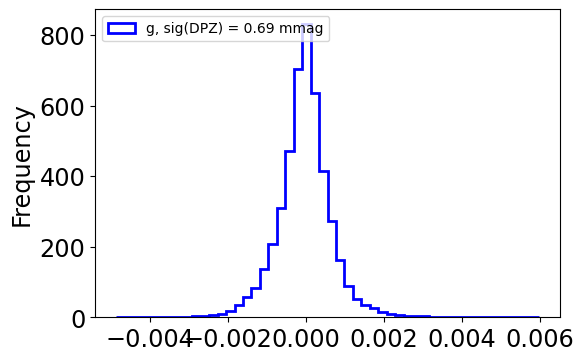

In [64]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

std = dataJoined_subset["DZP"].std()*1000
label = f"{band}, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="b",lw=2,label=label)
ax.legend(loc="upper left")

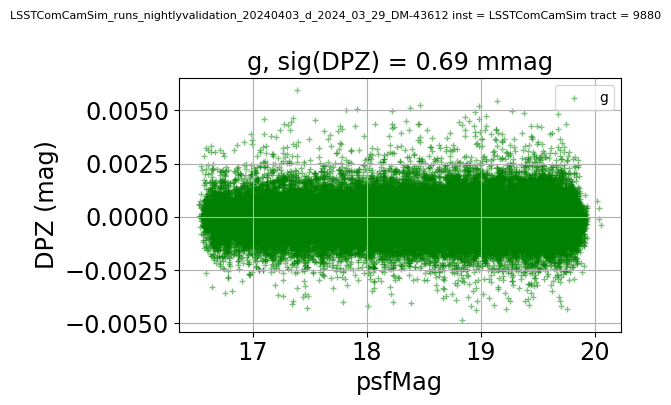

In [65]:
fig,ax = plt.subplots(1,1,figsize=(6,4),sharex=True,sharey=True)

dataJoined_subset.plot.scatter(x="psfMag",y="DZP",ax=ax,color="g",marker="+",lw=1,label="g",title=label,grid=True,alpha=0.5)

ax.set_ylabel("DPZ (mag)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

### scatter plot on psf Flux vs aperture flux

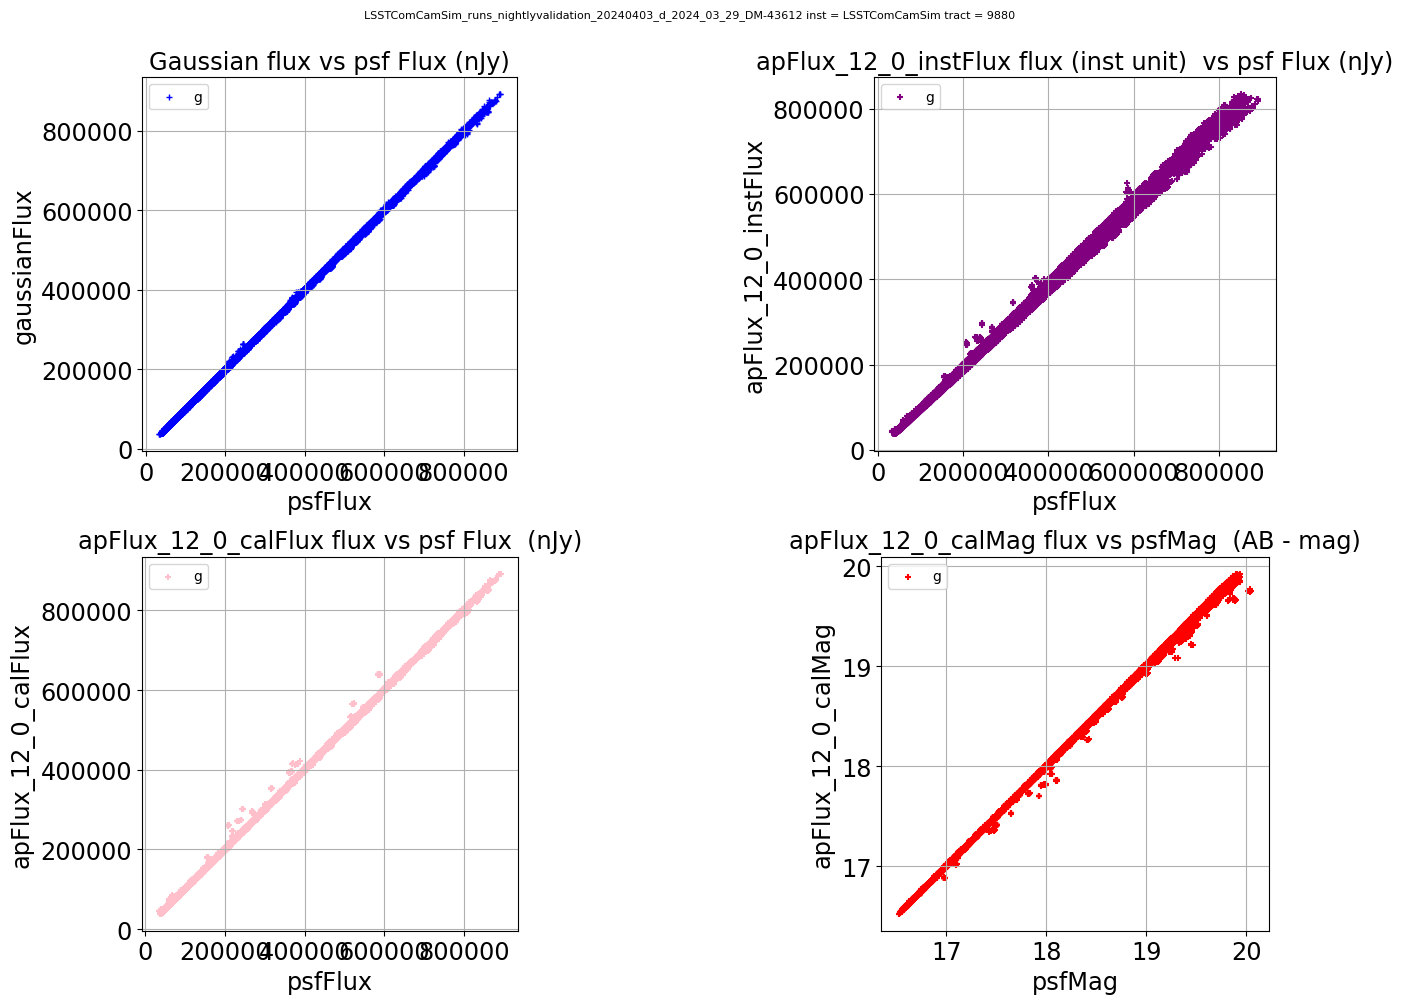

In [66]:
fig,axes = plt.subplots(2,2,figsize=(16,10))
axs = axes.flatten()

ax=axs[0]
dataJoined_subset.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="b",marker="+",lw=1,label=band)
ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title("Gaussian flux vs psf Flux (nJy)")
ax.grid()

ax=axs[1]
dataJoined_subset.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="purple",marker="+",label=band)
ax.set_aspect("equal")
ax.set_title(f"{calibFluxStr} flux (inst unit)  vs psf Flux (nJy)")
ax.grid()

ax=axs[2]
dataJoined_subset.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="pink",marker="+",label=band)
ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title(f"{calibFluxCalStr} flux vs psf Flux  (nJy)")
ax.grid()

ax=axs[3]
dataJoined_subset.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="r",marker="+",label=band)

ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title(f"{calibFluxCalMagStr} flux vs psfMag  (AB - mag)")
ax.grid()


plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

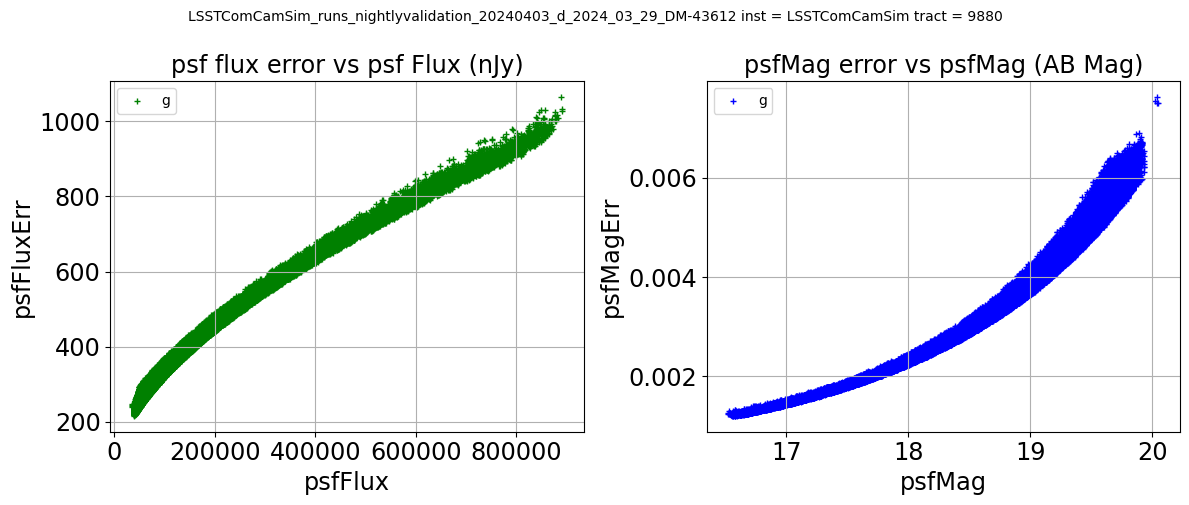

In [67]:
fig,axs = plt.subplots(1,2,figsize=(12,5))
ax=axs[0]
dataJoined_subset.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="g",marker="+",lw=1,label=band)
ax.set_aspect("auto")
ax.set_title("psf flux error vs psf Flux (nJy)")
ax.grid()

ax=axs[1]
dataJoined_subset.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="b",marker="+",lw=1,label=band)
ax.set_aspect("auto")
ax.set_title("psfMag error vs psfMag (AB Mag)")
ax.grid()

plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

## Plot the per object source 

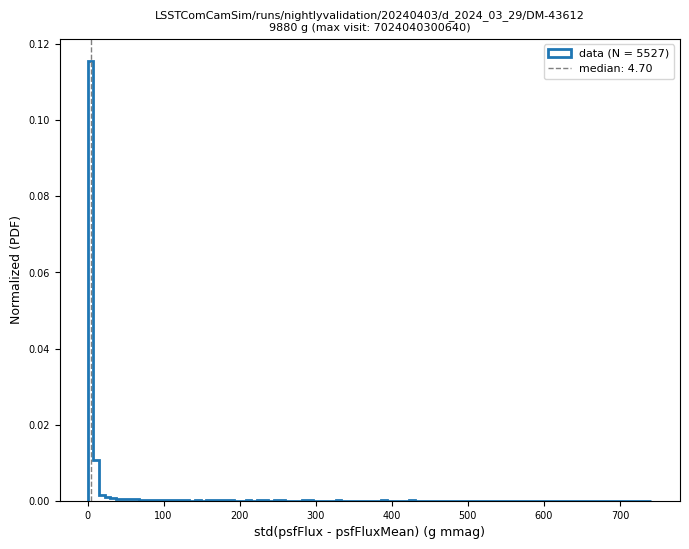

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)
#nBins = 16 if len(dataJoined) < 4000 else 100
nBins = 32 if len(dataJoined) < 4000 else 100
histData = psfMagStdMmagAll
xLabelStr = "std(psfFlux - psfFluxMean) ({} mmag)".format(band)
medianPsfFluxStd = np.median(histData)
n, bins, patches = ax.hist(histData, bins=nBins, density=True, histtype="step", lw=2, label="data (N = {})".format(len(histData)))
ax.axvline(x=medianPsfFluxStd, color="gray", linestyle='--', linewidth=1, label="median: {:.2f}".format(medianPsfFluxStd))

ax.tick_params(labelsize=7)
ax.set_xlabel(xLabelStr, fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}psfFluxStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

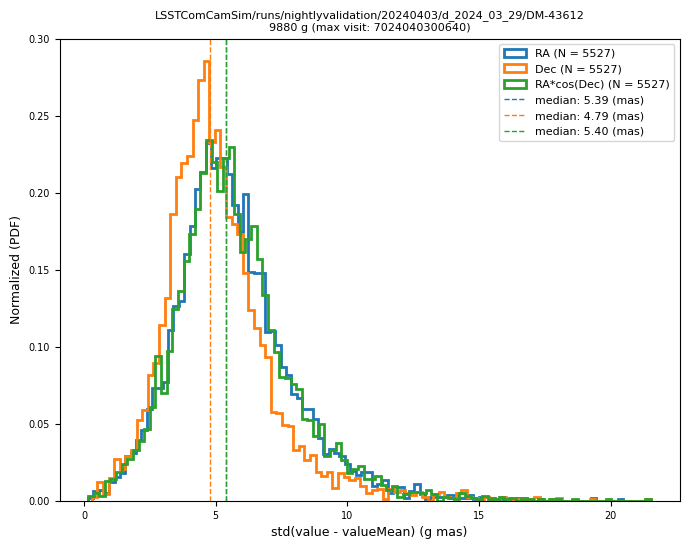

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)

medianRaStd = np.median(raStdMasAll)
n, bins, patches = ax.hist(raStdMasAll, bins=nBins, density=True, histtype="step", color="tab:blue", lw=2, label="RA (N = {})".format(len(raStdMasAll)))

medianDecStd = np.median(decStdMasAll)
n, bins, patches = ax.hist(decStdMasAll, bins=nBins, density=True, histtype="step", color="tab:orange", lw=2, label="Dec (N = {})".format(len(decStdMasAll)))

medianRaCosDecStd = np.median(raCosDecStdMasAll)
n, bins, patches = ax.hist(raCosDecStdMasAll, bins=nBins, density=True, histtype="step", color="tab:green", lw=2, label="RA*cos(Dec) (N = {})".format(len(raCosDecStdMasAll)))

ax.axvline(x=medianRaStd, linestyle='--', color="tab:blue", linewidth=1, label="median: {:.2f} (mas)".format(medianRaStd))
ax.axvline(x=medianDecStd, linestyle='--', color="tab:orange", linewidth=1, label="median: {:.2f} (mas)".format(medianDecStd))
ax.axvline(x=medianRaCosDecStd, linestyle='--', color="tab:green", linewidth=1, label="median: {:.2f} (mas)".format(medianRaCosDecStd))


ax.tick_params(labelsize=7)
ax.set_xlabel("std(value - valueMean) ({} mas)".format(band), fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

# ax.set_xlim(0, 400)
ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}RaDecStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

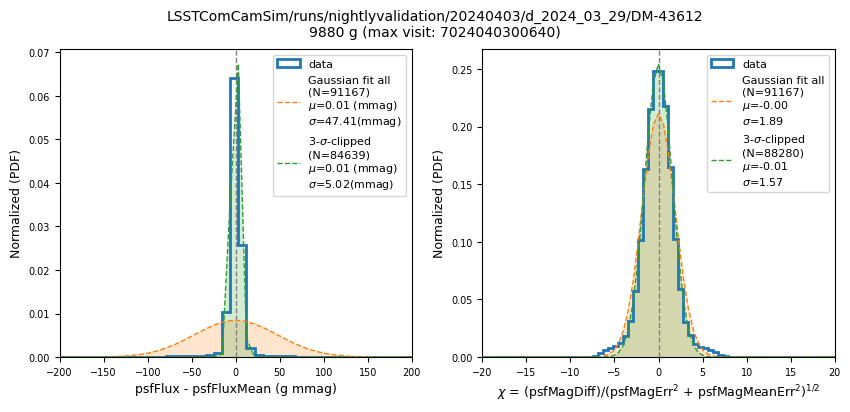

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffMmag"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f} (mmag)\n$\sigma$={:.2f}(mmag)".format(len(dataJoined), mu, sigma))
ax1.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffMmag"], low=3.0, high=3.0).clipped

(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax1.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f} (mmag) \n$\sigma$={:.2f}(mmag)".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax1.fill_between(bins, yFitClipped, alpha=0.2)

ax1.tick_params(labelsize=7)
ax1.set_xlabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax1.set_xlim(-200, 200)
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
n, bins, patches = ax2.hist(dataJoined["psfMagDiffChi"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffChi"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(dataJoined), mu, sigma))
ax2.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffChi"], low=3.0, high=3.0).clipped
(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax2.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax2.fill_between(bins, yFitClipped, alpha=0.2)

ax2.tick_params(labelsize=7)
ax2.set_xlabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax2.set_xlim(-20, 20)
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

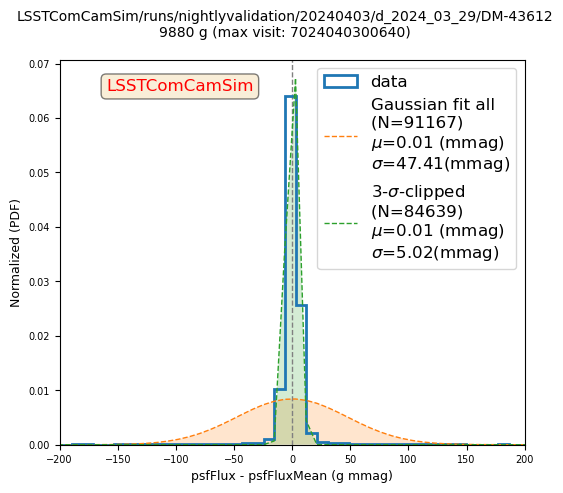

In [71]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffMmag"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f} (mmag)\n$\sigma$={:.2f}(mmag)".format(len(dataJoined), mu, sigma))
ax1.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffMmag"], low=3.0, high=3.0).clipped

(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax1.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f} (mmag) \n$\sigma$={:.2f}(mmag)".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax1.fill_between(bins, yFitClipped, alpha=0.2)

ax1.tick_params(labelsize=7)
ax1.set_xlabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax1.set_xlim(-200, 200)
ax1.legend(fontsize=12,loc="upper right")
ax1.text(0.1, 0.95, "LSSTComCamSim", transform=ax1.transAxes, fontsize=12,color="red",verticalalignment='top', bbox=props)
figname = f"photomrepeat_band_{band}_LSSTComCamSim.png"
plt.savefig(figname)
plt.show()

In [72]:
Band_To_Cmap_Dict = {"g":plt.cm.Greens,"r":plt.cm.Reds,"i":plt.cm.Oranges,"z":plt.cm.Purples,"y":plt.cm.Greys}

/tmp/ipykernel_4844/3215363886.py:14: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend(fontsize=8)


/tmp/ipykernel_4844/3215363886.py:27: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax2.legend(fontsize=8)


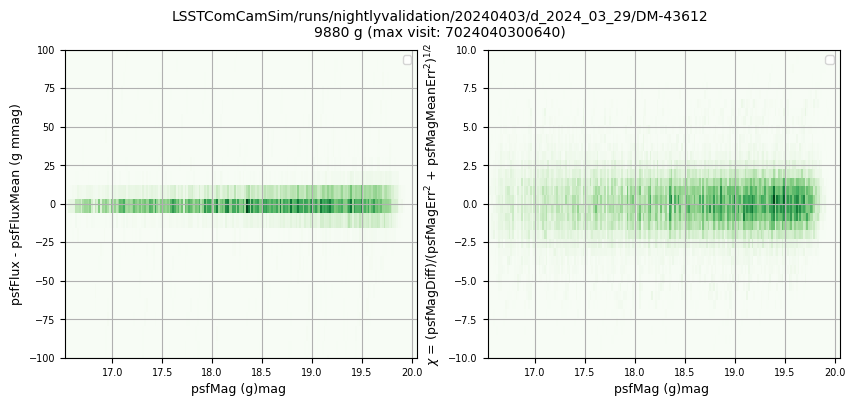

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,100), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax1.set_ylim(-100, 100)
ax1.legend(fontsize=8)
ax1.grid()

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,100),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax2.set_ylim(-10, 10)
ax2.legend(fontsize=8)
ax2.grid()

if doSaveFigs:
    filename = "{}psfFluxDiffHist2D_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [74]:
# Split out the smallest and largest PSF mag std objects (just to easily look at the extremes).
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] >= 1.4*medianPsfFluxStd]
smallStdList= [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < 0.4*medianPsfFluxStd]
for objectIndex in largeStdList:
    print("Large Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))
for objectIndex in smallStdList:
    print("Small Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))

Large Std: objectIndex = 66  number of matches = 36
Large Std: objectIndex = 67  number of matches = 34
Large Std: objectIndex = 87  number of matches = 13
Large Std: objectIndex = 90  number of matches = 37
Large Std: objectIndex = 102  number of matches = 14
Large Std: objectIndex = 142  number of matches = 33
Large Std: objectIndex = 147  number of matches = 25
Large Std: objectIndex = 157  number of matches = 34
Large Std: objectIndex = 185  number of matches = 36
Large Std: objectIndex = 188  number of matches = 34
Large Std: objectIndex = 197  number of matches = 33
Large Std: objectIndex = 203  number of matches = 11
Large Std: objectIndex = 211  number of matches = 30
Large Std: objectIndex = 222  number of matches = 38
Large Std: objectIndex = 223  number of matches = 40
Large Std: objectIndex = 227  number of matches = 27
Large Std: objectIndex = 228  number of matches = 34
Large Std: objectIndex = 231  number of matches = 37
Large Std: objectIndex = 236  number of matches = 

numObj = 12 [with obj_index = 3269]
numObj = 5 [with obj_index = 3372]
numObj = 26 [with obj_index = 3799]
numObj = 34 [with obj_index = 67]


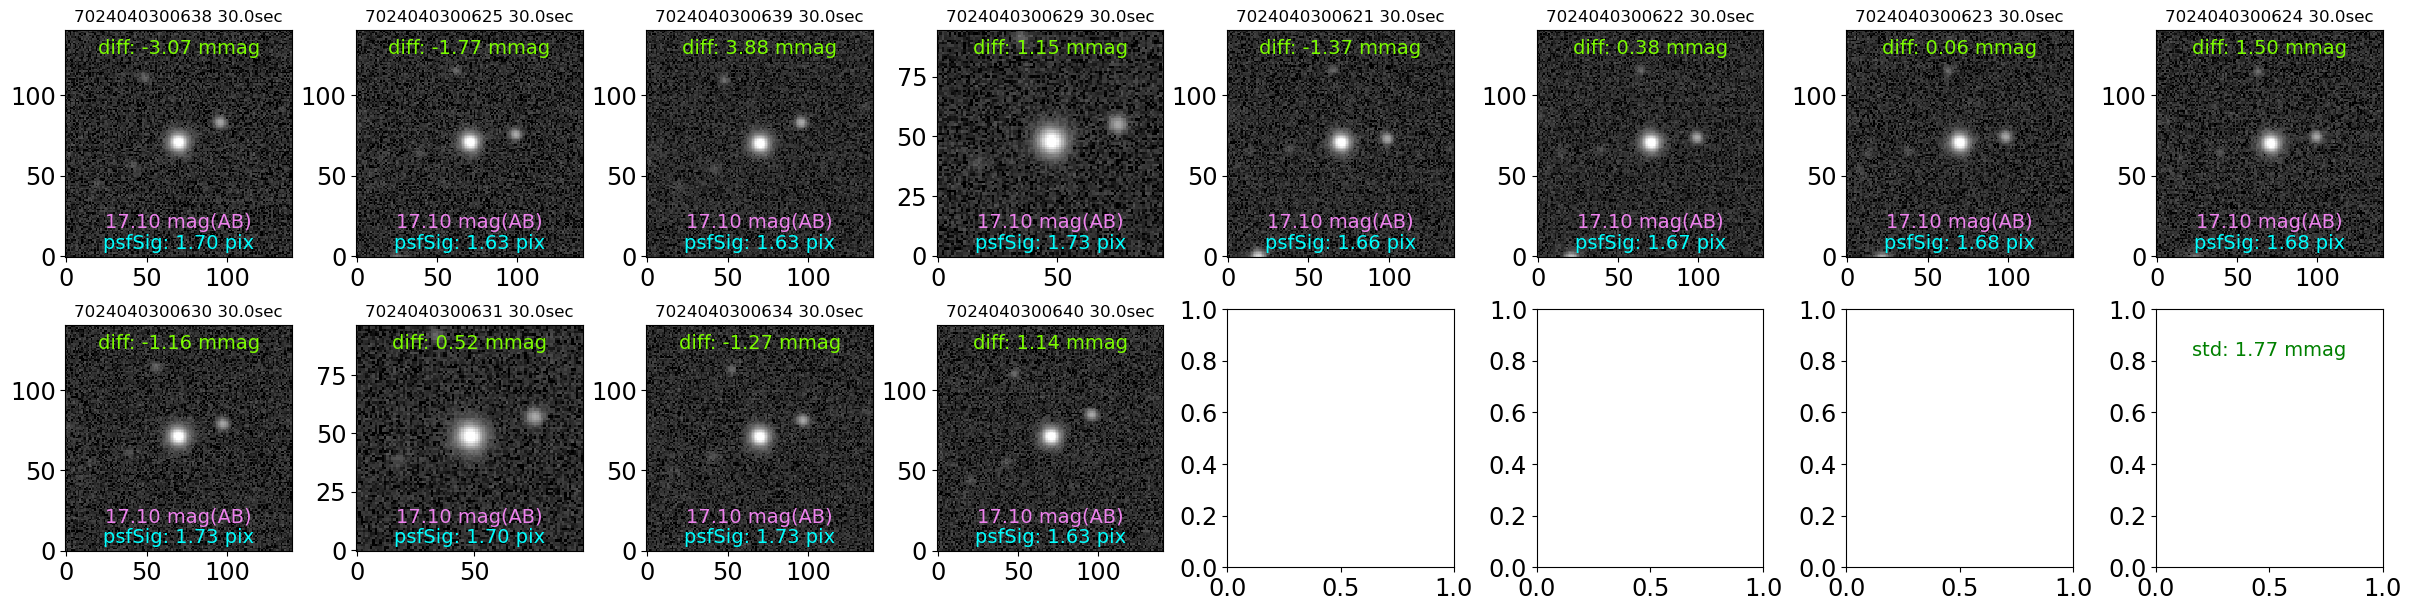

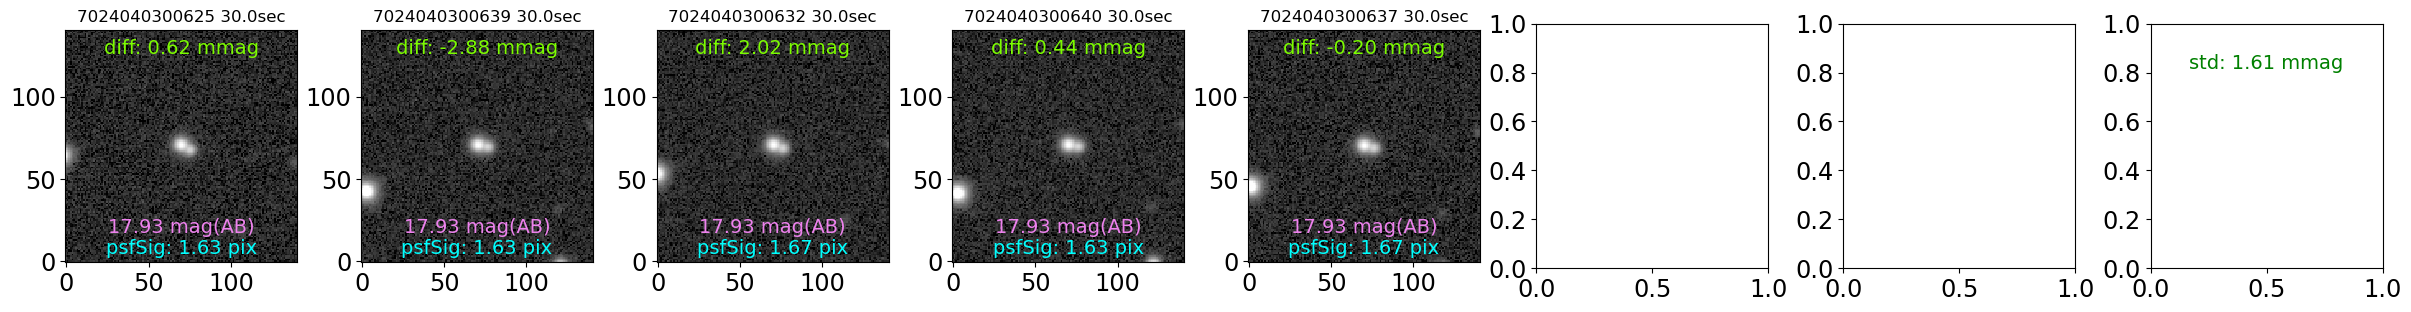

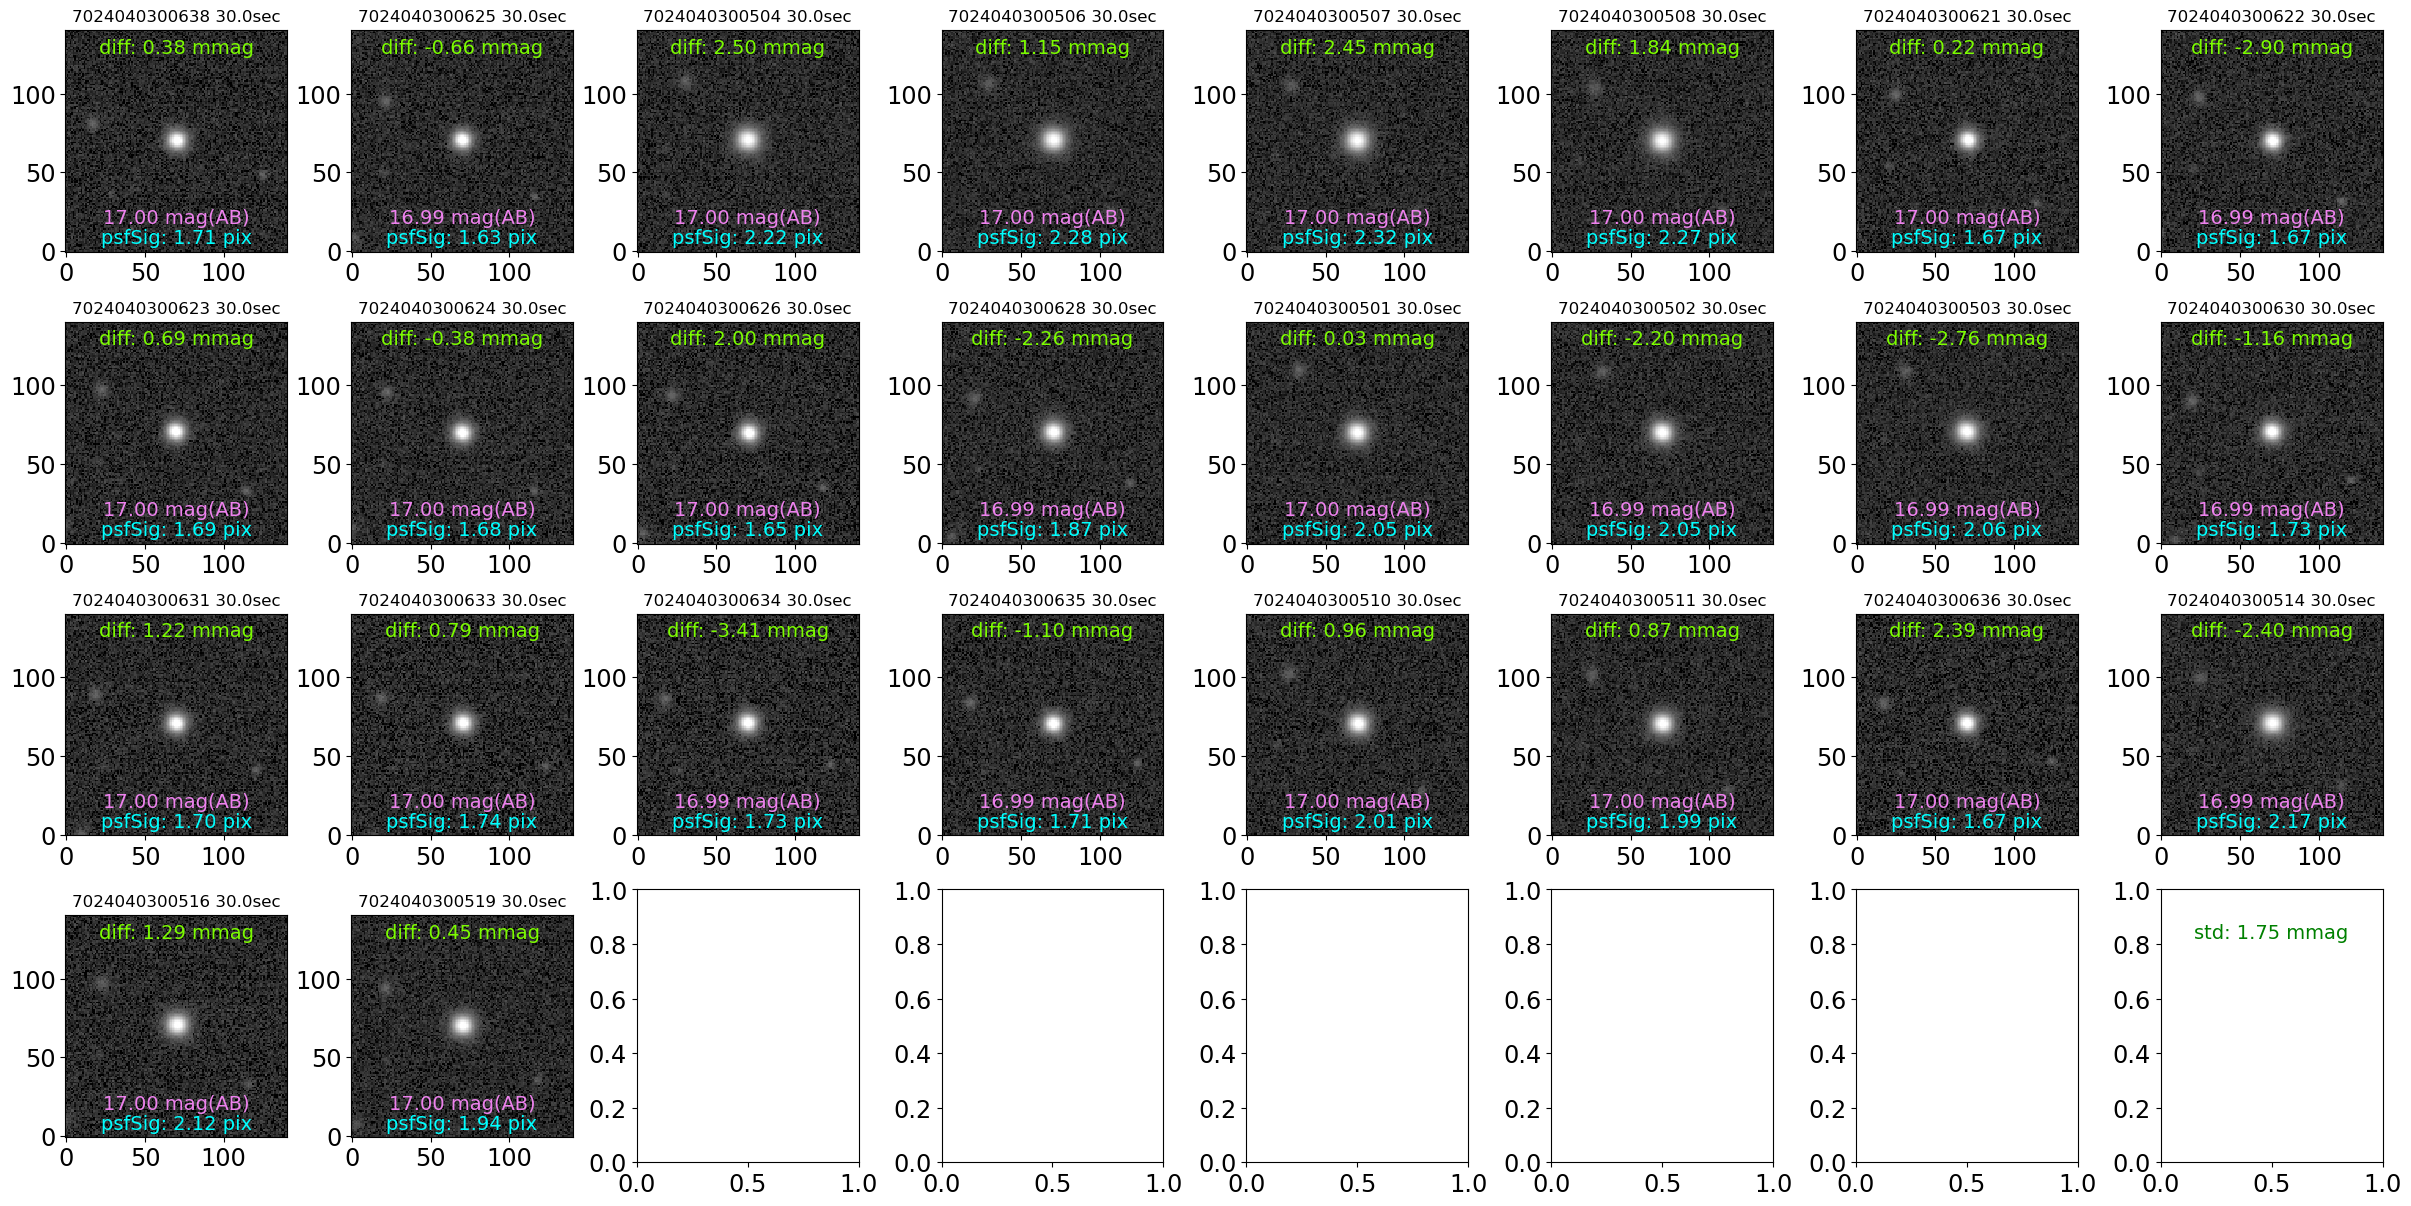

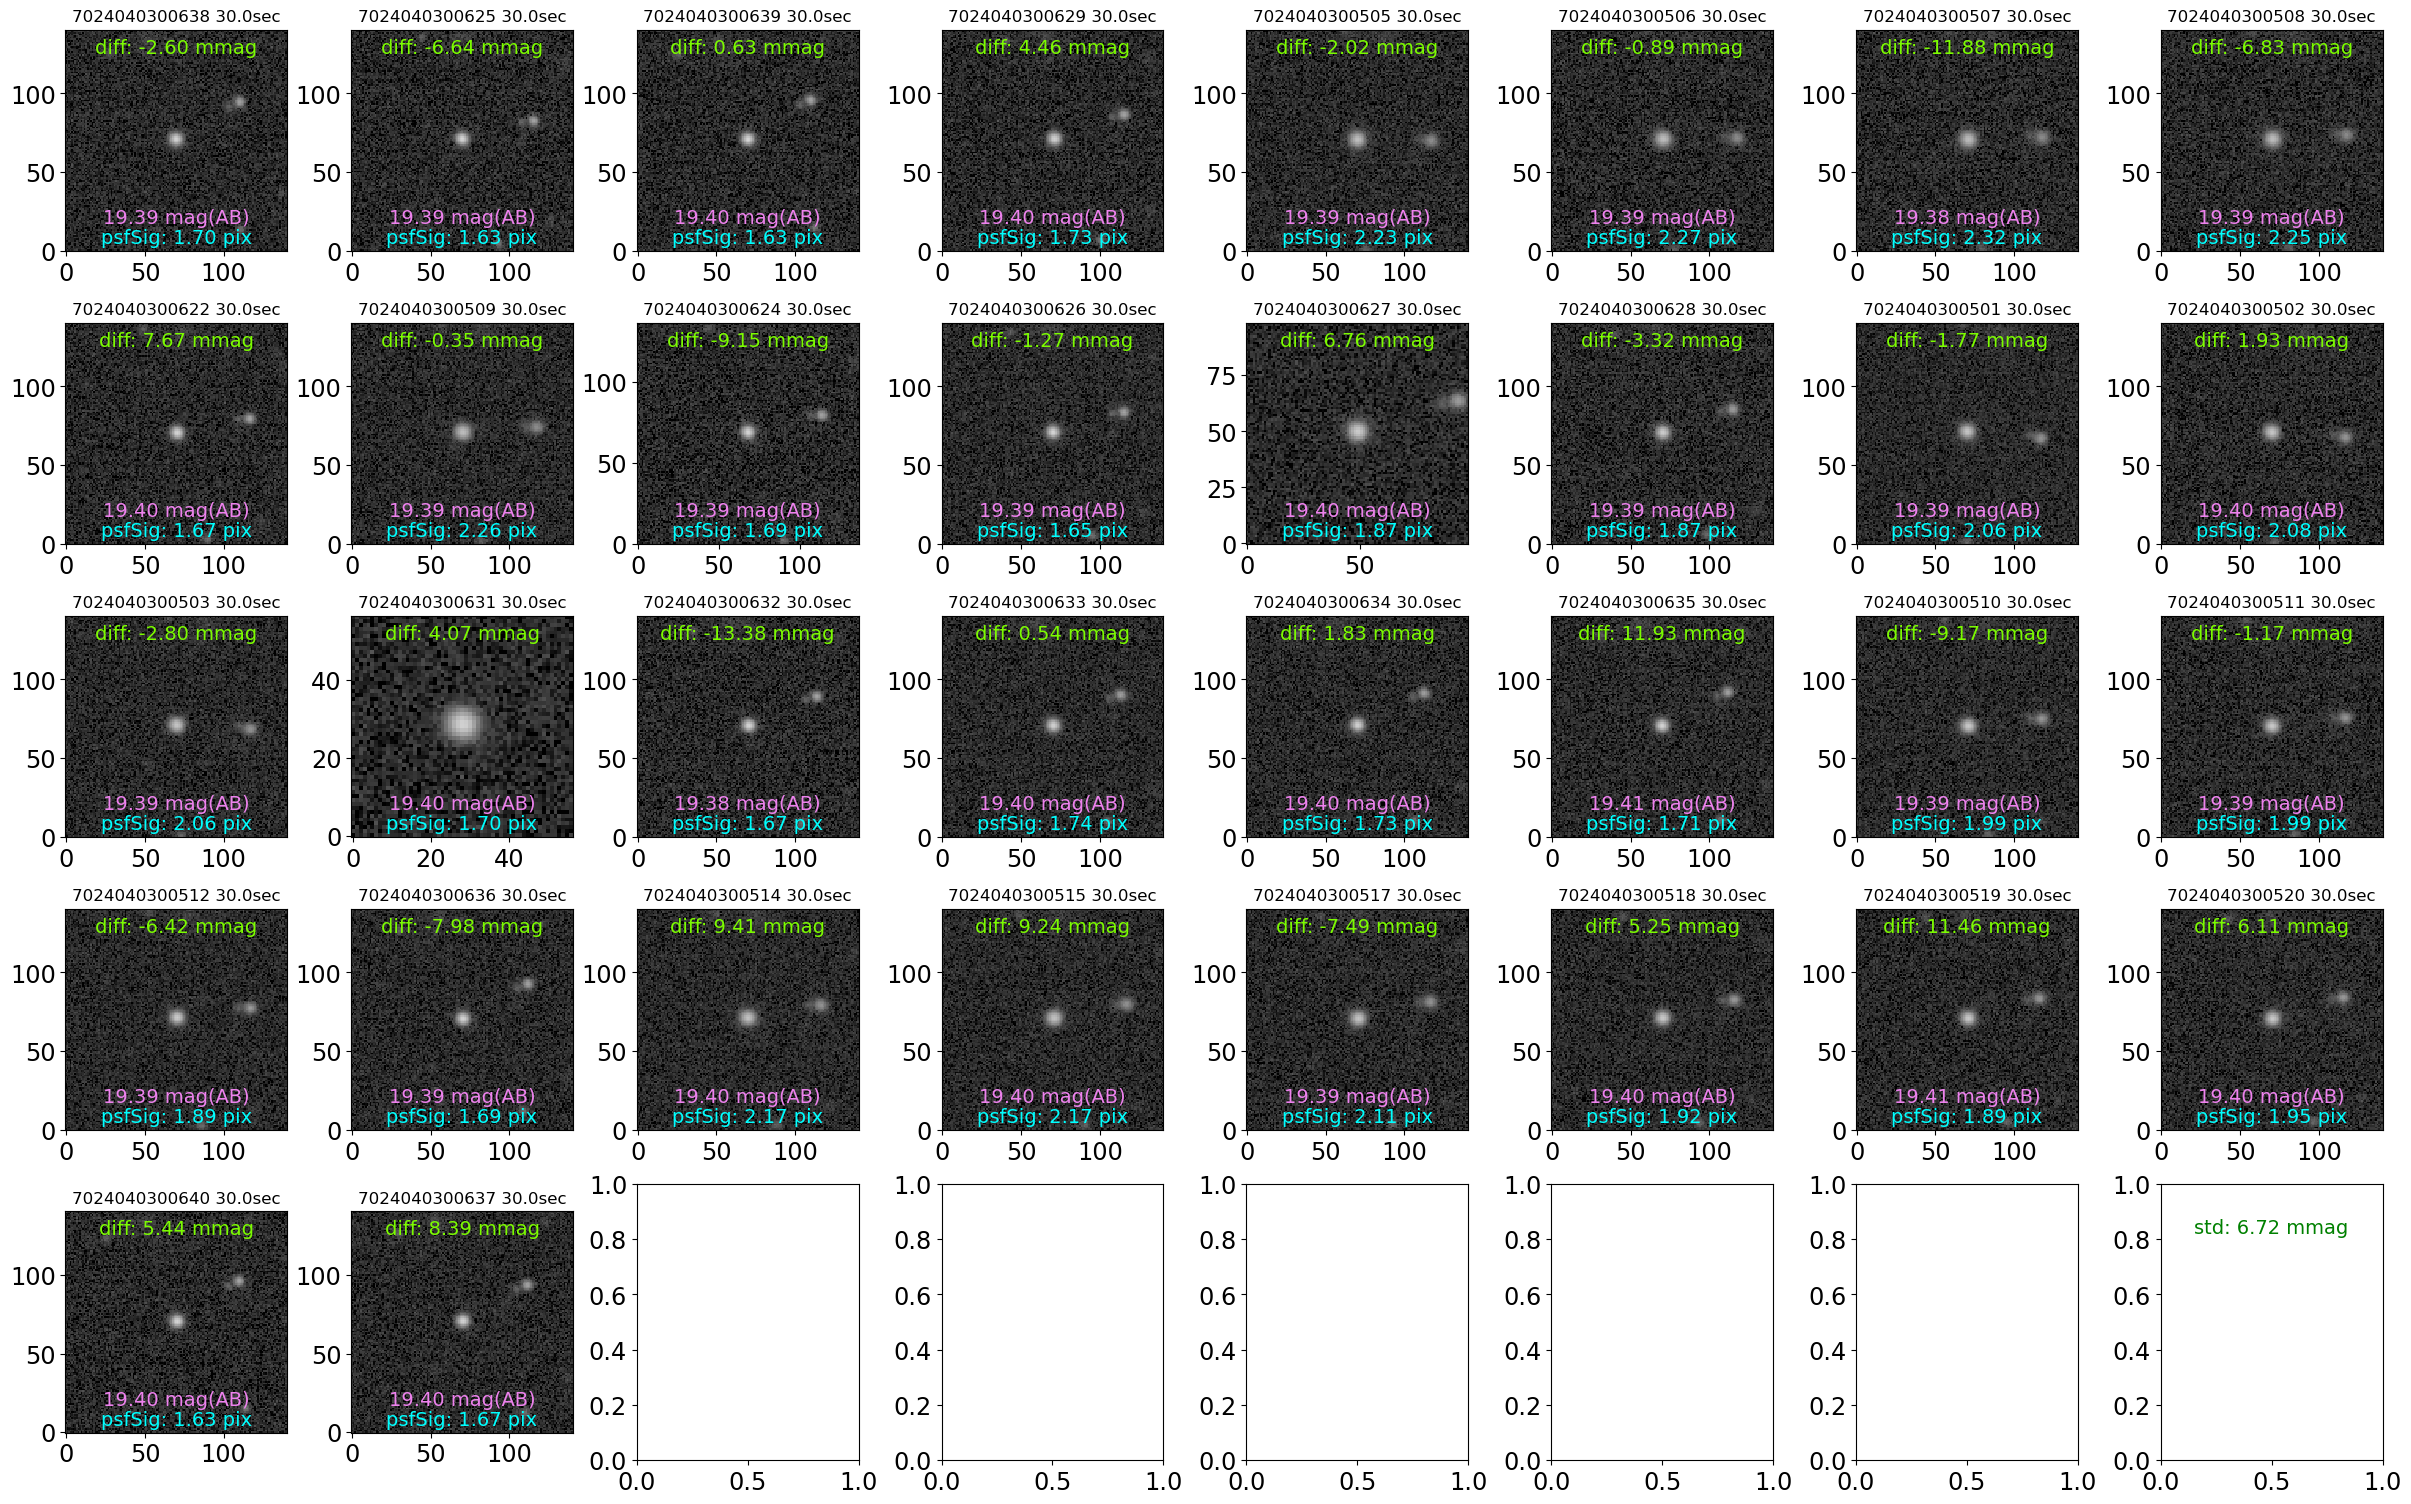

In [75]:
# Plot cutouts centered on matched sources from different visits for a couple of objects.
# Selecting from the small/largeStdLists made above to look at the extremes.
imMin, imMax, Q = -0.001, 0.004, 8
expMin, expMax = -25, 100
numSub = 8
for maxBoxSize in [71]:
    plt.close("all")
    for objInd in smallStdList[0:3] + largeStdList[1:2]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        numObj = len(joinedObjects)
        print("numObj = {} [with obj_index = {}]".format(numObj, objInd))
        nRow = 1 if numObj <= numSub else (numObj // numSub) + 1
        # print("nRow = {}".format(nRow))
        fig, axes = plt.subplots(nRow, numSub, figsize=(3*numSub, 3*nRow), constrained_layout=True)
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        
        psfMag = joinedObjects["psfMag"]
        psfMagErr = joinedObjects["psfMagErr"]
        psfMagDiffMmag = joinedObjects["psfMagDiffMmag"].values
        psfMagStdMmag = psfMagStdMmagDict[objInd]

        clippedMeanRaArray = scipy.stats.sigmaclip(joinedObjects["ra"], low=3.0, high=3.0).clipped
        clippedMeanRa = np.mean(clippedMeanRaArray)
        clippedMeanDecArray = scipy.stats.sigmaclip(joinedObjects["dec"], low=3.0, high=3.0).clipped
        clippedMeanDec = np.mean(clippedMeanDecArray)

        iObj = -1
        for ax in axes.ravel():
            iObj += 1
            if iObj < numObj:
                row = joinedObjects[iObj:iObj + 1]
                detector = row["detector"].values[0]
                visit = row["visit"].values[0]
                psfMag = (row["psfFlux"].values[0]*u.nJy).to(u.ABmag)

                dataId = {"detector": detector, "visit": visit}
                exp = butler.get("calexp", dataId)
                wcs = exp.wcs
                pt = geom.SpherePoint(geom.Angle(row["ra"].values[0], geom.degrees),
                                      geom.Angle(row["dec"].values[0], geom.degrees))
                (xSrc, ySrc) = wcs.skyToPixel(pt)

                boxSize = int(min(maxBoxSize, xSrc, exp.getWidth()-xSrc, ySrc, exp.getHeight()-ySrc) - 1)

                minBbox = geom.Point2I(int(xSrc) - boxSize ,int(ySrc) - boxSize)
                maxBbox = geom.Point2I(int(xSrc) + boxSize, int(ySrc) + boxSize)
                srcBbox = geom.Box2I(minBbox, maxBbox)

                subimg = afwImage.ExposureF(exp, srcBbox, afwImage.PARENT, True)
                subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)

                im = ax.imshow(subimgRgb, interpolation="nearest", origin="lower")
                ax.text(0.5, 0.06, "psfSig: {:.2f} pix".format(row["psfSigma"].values[0]),
                        color="cyan", fontsize=14, ha="center", va="center", transform=ax.transAxes)
                ax.text(0.5, 0.15, "{:.2f}".format(psfMag),
                        color="violet", fontsize=14, ha="center", va="center", transform=ax.transAxes)

                diffColor = "red" if np.abs(psfMagDiffMmag[iObj]) > 100 else "lawngreen"
                ax.text(0.5, 0.92, "diff: {:.2f} mmag".format(psfMagDiffMmag[iObj]),
                        color=diffColor, fontsize=14, ha="center", va="center", transform=ax.transAxes)

                ax.set_title("{} {}sec".format(visit, row["expTime"].values[0]), fontsize=12)

        color = "green"
        plt.text(0.5, 0.84, "std: {:.2f} mmag".format(psfMagStdMmag), color=color, fontsize=14,
                 ha="center", va="center", transform=ax.transAxes)

        if doSaveFigs:
            filename = "{}{}_allOjbectsSmallStd_{}_{}_{}".format(saveDir, camera.getName(), objInd, maxBoxSize, collectionStr)
            print("Saving file in: {}".format(filename))
            plt.savefig(filename, dpi=250)

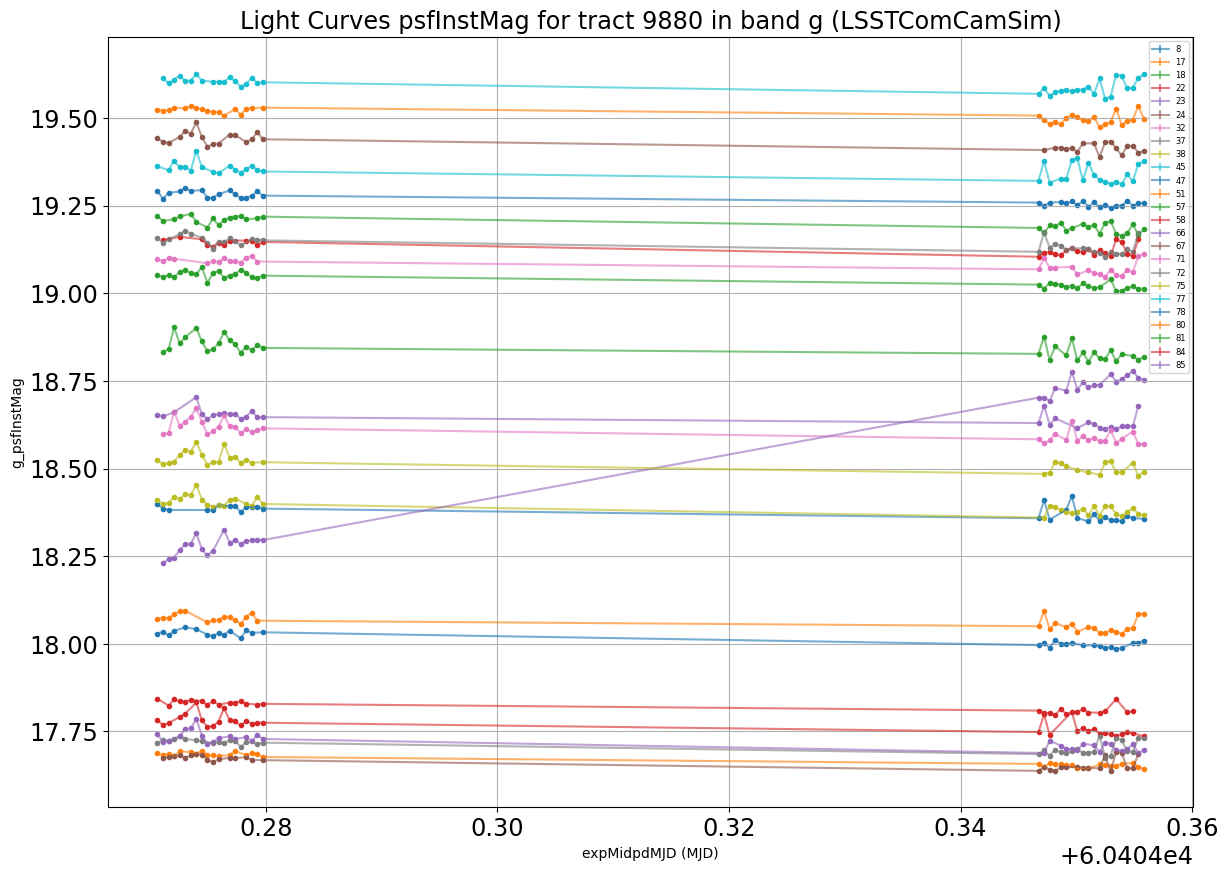

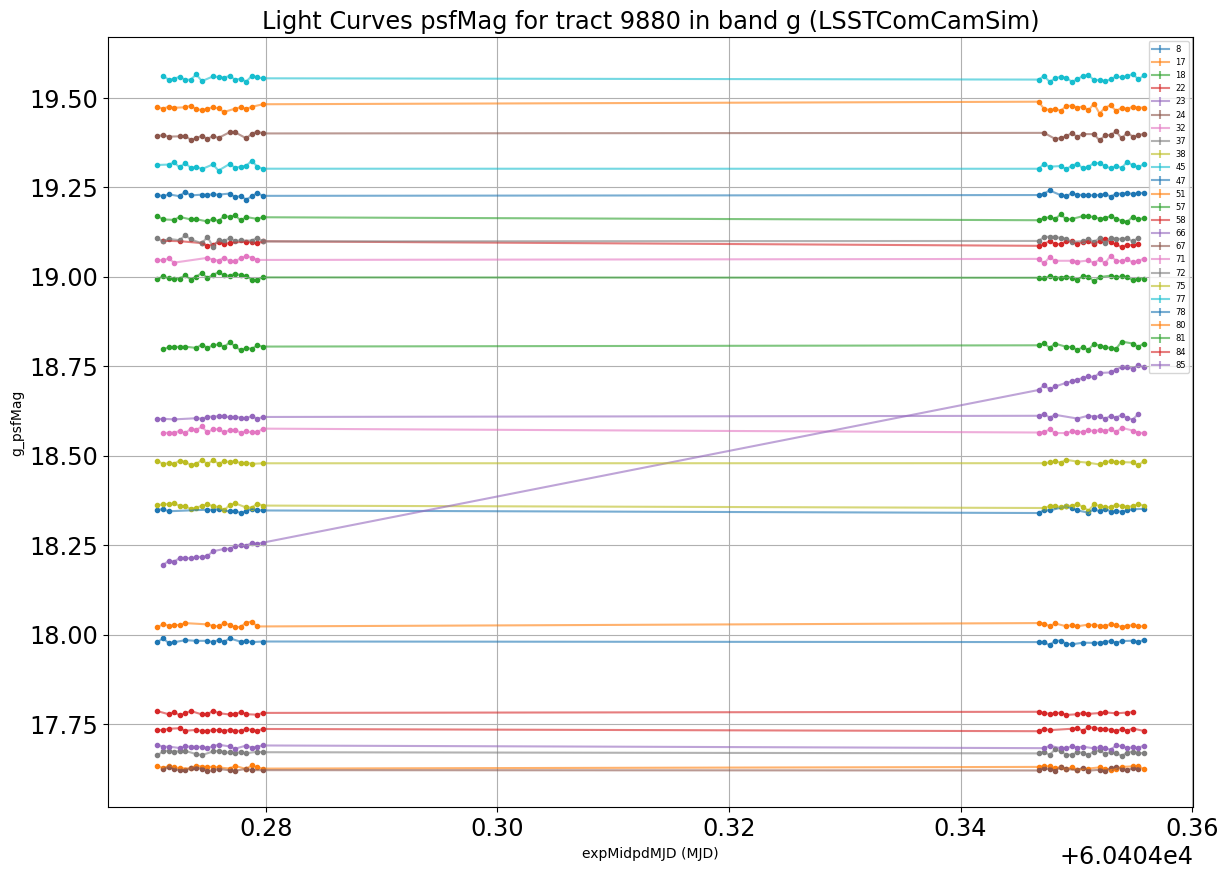

In [76]:
# Plot all light curves (or as many as you include from stdList)
stdList = [index for index in psfMagStdMmagDict]
# Make light curves for both:
#     psfInstMag: the "instrument" magnitude
#     psfMag: the calibrated magnitude
for magStr in ["psfInstMag", "psfMag"]:
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    for objInd in stdList[:25]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMJD"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6, loc="upper right")
    ax.set_xlabel("{}{}".format("expMidpdMJD", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_{}".format(band, magStr), fontsize=10)
    title = f"Light Curves {magStr} for tract {tract} in band {band} (LSSTComCamSim)"
    ax.set_title(title)
    if doSaveFigs:
        filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
        print("Saving file in: {}".format(filename))
        plt.savefig(filename, dpi=150)
    ax.grid()

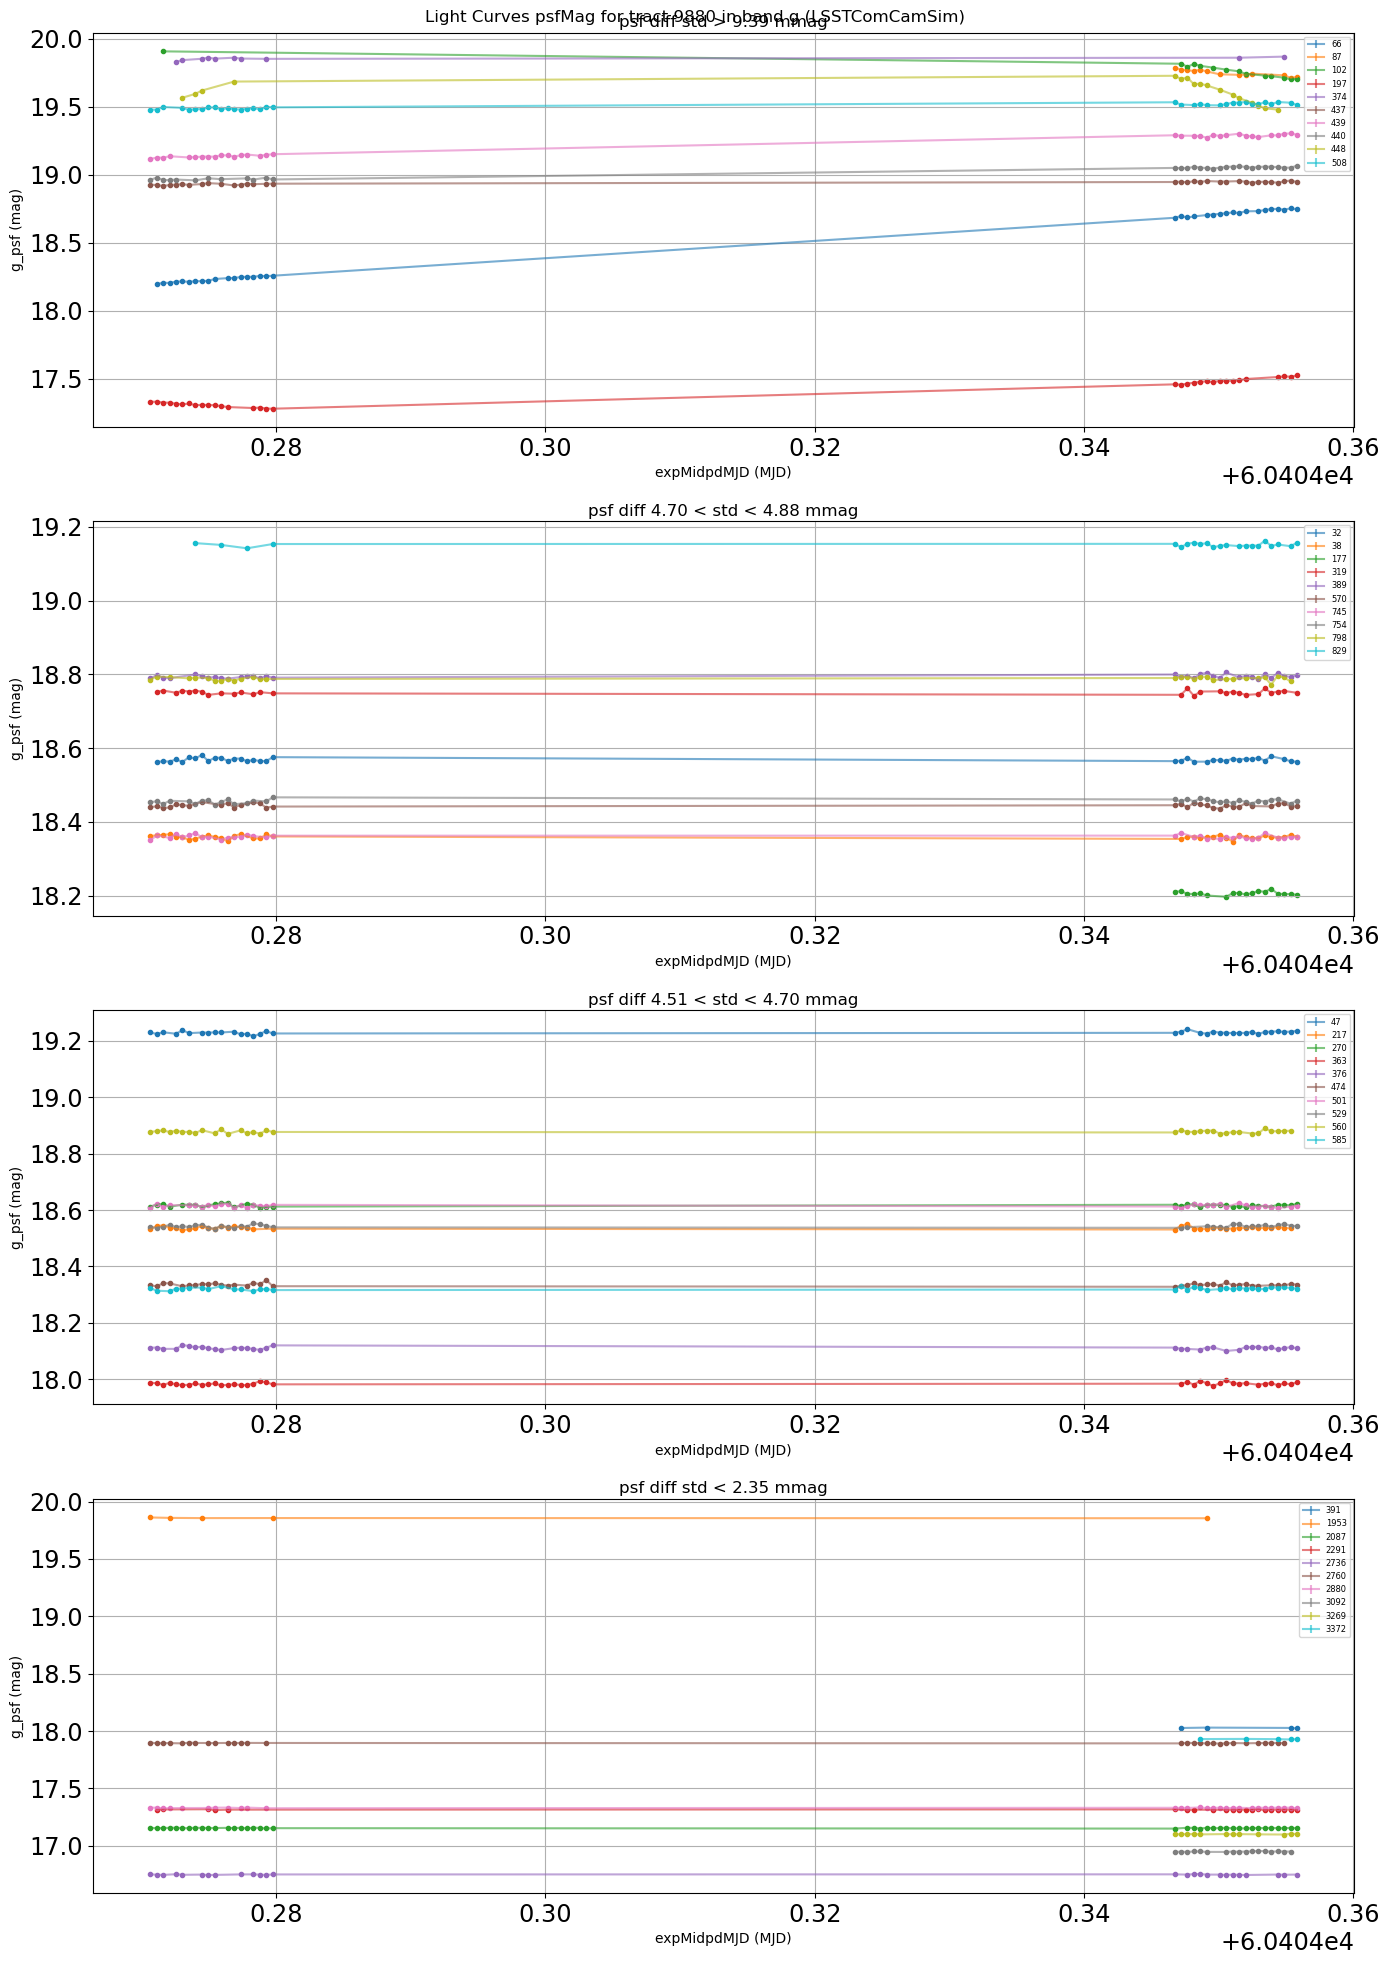

In [77]:
# Plot light curves divided by photo Std
magStr = "psfMag"
largeThresh = min(2.0*medianPsfFluxStd, 0.8*max(psfMagStdMmagDict.values()))
smallThresh = max(0.5*medianPsfFluxStd, 0.2*min(psfMagStdMmagDict.values()))
mediumThreshLower = medianPsfFluxStd - 0.04*medianPsfFluxStd
mediumThreshUpper = medianPsfFluxStd + 0.04*medianPsfFluxStd
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] > largeThresh]
mediumUpperStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < mediumThreshUpper and psfMagStdMmagDict[index] > medianPsfFluxStd)]
mediumLowerStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < medianPsfFluxStd and psfMagStdMmagDict[index] > mediumThreshLower)]
smallStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < smallThresh]
titleStrList = ["psf diff std > {:.2f} mmag".format(largeThresh),
                "psf diff {:.2f} < std < {:.2f} mmag".format(medianPsfFluxStd, mediumThreshUpper),
                "psf diff {:.2f} < std < {:.2f} mmag".format(mediumThreshLower, medianPsfFluxStd),
                "psf diff std < {:.2f} mmag".format(smallThresh)]

fig, axes = plt.subplots(4, 1, figsize=(14, 20))
for stdList, titleStr, ax in zip([largeStdList[:10], mediumUpperStdList[:10], mediumLowerStdList[:10], smallStdList[:10]], titleStrList, axes):
    for objInd in stdList:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMJD"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6)
    ax.set_xlabel("{}{}".format("expMidpdMJD", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_psf (mag)".format(band), fontsize=10)
    ax.set_title(titleStr, fontsize=12, pad=4)
    ax.grid()
suptitle = f"Light Curves {magStr} for tract {tract} in band {band} (LSSTComCamSim)"
plt.suptitle(suptitle)
plt.tight_layout()
if doSaveFigs:
    filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
    print("Saving file in: {}".format(filename))
    plt.savefig(filename, dpi=150)
plt.tight_layout()

## Select the objects

In [78]:
#index_min = min(psfMagMeanMagDict, key=psfMagMeanMagDict.get)
index_min, magmin = min(psfMagMeanMagDict.items(), key=lambda x: x[1]) 

In [79]:
index_min, magmin

(23944, 16.536101817380924)

In [80]:
psfMagStdMmagDict[index_min]

12.13242751462674

In [81]:
index_sel = index_min

In [82]:
the_selected_object = objDataList[index_sel]
the_selected_object

sourceId        psfFlux   psfFluxErr  psfFlux_flag  \
13632  3065474144884752550  872049.296387  1006.012555         False   
40922  3065474140589786496  865908.690435  1001.134329         False   
71025  3065474154548430505  884263.698668  1008.419338         False   
77446  3065474157769655215  890828.543683  1032.097296         False   
79593  3065474158843396728  888781.476445  1063.253215         False   
84003  3065474160990880677  891603.138753  1027.732778         False   

       psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
13632        0.991101                0.0           0.0              True   
40922        0.990600                0.0           0.0              True   
71025        0.990250                0.0           0.0              True   
77446        0.989676                0.0           0.0              True   
79593        0.993640                0.0           0.0              True   
84003        0.992975                0.0           0.0              True   

       deblend_skipped   gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
13632            False  870320.445906      1161.235289              False   
40922            False  862363.973587      1135.319021              False   
71025            False  885550.273455      1142.980912              False   
77446            False  891060.763173      1189.267194              False   
79593            False  890996.587176      1157.957990              False   
84003            False  891501.723483      1178.775507              False   

       localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
13632         1.096509            0.000431                 False  26210   
40922         1.093142            0.000445                 False  29128   
71025         1.092102            0.000418                 False  28443   
77446         1.089073            0.000492                 False  28039   
79593         1.083621            0.000584                 False  29223   
84003         1.084202            0.000471                 False  29134   

               visit  detector          ra       dec physical_filter band  \
13632  7024040300505         8  250.422562  1.955013            g_01    g   
40922  7024040300501         8  250.422564  1.955013            g_01    g   
71025  7024040300514         8  250.422563  1.955014            g_01    g   
77446  7024040300517         8  250.422568  1.955011            g_01    g   
79593  7024040300518         8  250.422564  1.955012            g_01    g   
84003  7024040300520         8  250.422563  1.955013            g_01    g   

       apFlux_12_0_instFlux  apFlux_12_0_instFluxErr            x  \
13632           794019.9375               796.113403  3541.057474   
40922           791013.2500               796.952209  2948.414810   
71025           810369.3750               812.940247  2245.919636   
77446           817895.6875               828.616455  1548.055745   
79593           822092.8750               825.237976   710.728679   
84003           822319.5625               828.829041  2535.813741   

                 y      xErr      yErr  apFlux_17_0_instFlux  \
13632   279.914747  0.004097  0.003802         805044.745296   
40922  2498.877688  0.003724  0.003454         799403.155763   
71025  3114.444421  0.004046  0.003543         821613.070264   
77446  1757.918061  0.003934  0.003419         827667.591894   
79593  1062.847380  0.003549  0.003102         826820.493535   
84003  1680.347242  0.003594  0.003137         828331.292652   

       apFlux_17_0_instFluxErr  apFlux_17_0_flag  localBackground_instFlux  \
13632               892.721046             False                  2.508095   
40922               896.179567             False                  2.195100   
71025               919.143147             False                  2.206086   
77446               942.064865             False                  2.076336   
79593               933.204785             False   

In [83]:
row_obj = df_obj[df_obj.objindex==index_sel]

In [84]:
this_object_output_file = 'sources_'+output_objects_file.replace(output_objects_file_truncated,output_objects_file_truncated+f"-o{index_sel}")   

In [85]:
output_objects_file

'objectTable-t9880-bg-LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612.csv'

In [86]:
the_selected_object.to_csv(this_object_output_file)

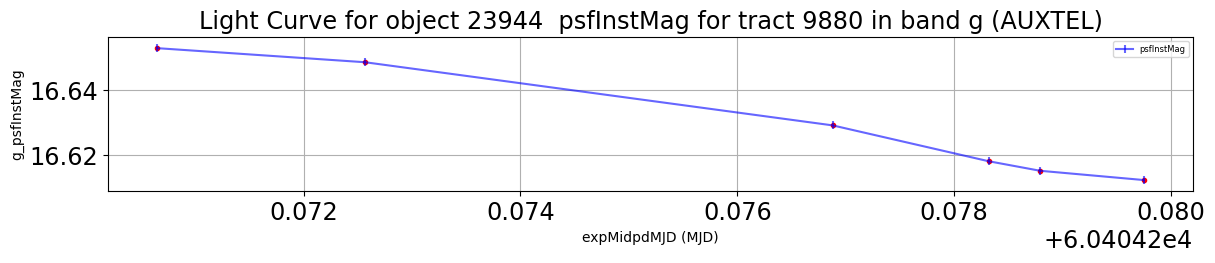

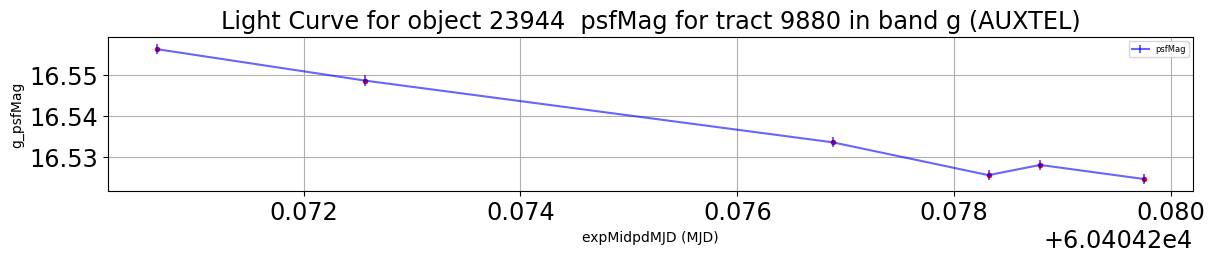

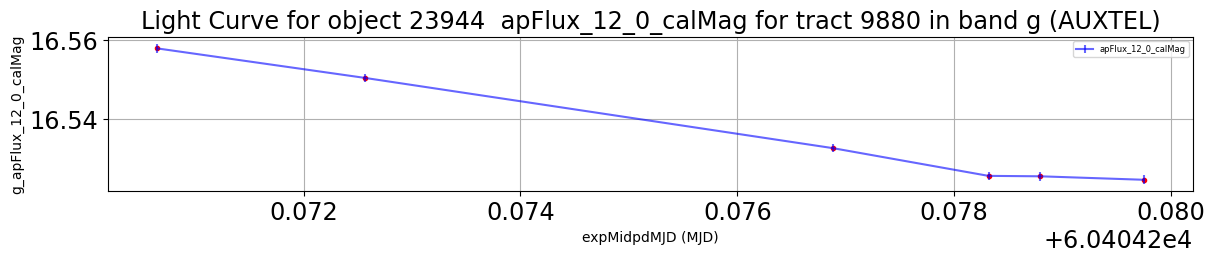

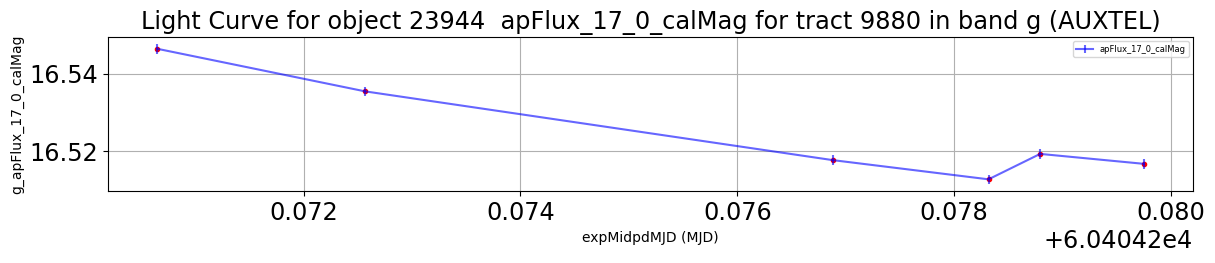

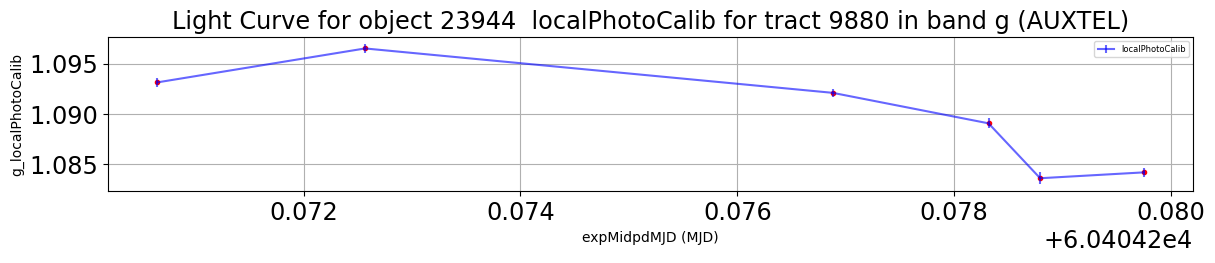

In [87]:
for magStr in ["psfInstMag", "psfMag","apFlux_12_0_calMag","apFlux_17_0_calMag","localPhotoCalib"]:  
    magerrStr = magStr+"Err"
    fig, ax = plt.subplots(1, 1, figsize=(14, 2))   
    xData = the_selected_object["expMidptMJD"]
    yData = the_selected_object[magStr]
    yDataErr = the_selected_object[magerrStr]
    yDataSorted = [y for _, y in sorted(zip(xData, yData))]
    yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
    xDataSorted = sorted(xData)
    
    ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", color="b",alpha=0.6, label=f"{magStr}".format(objInd))
    ax.scatter(xDataSorted, yDataSorted, s=9, c='r',alpha=1.0)
    ax.grid()

    
    ax.legend(fontsize=6, loc="upper right")
    ax.set_xlabel("{}{}".format("expMidpdMJD", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_{}".format(band, magStr), fontsize=10)
    title = f"Light Curve for object {index_sel}  {magStr} for tract {tract} in band {band} (AUXTEL)"
    ax.set_title(title)

In [88]:
print("smallStdList = ", smallStdList)

smallStdList =  [391, 1953, 2087, 2291, 2736, 2760, 2880, 3092, 3269, 3372, 3646, 3799, 4004, 4222, 4326, 5163, 5383, 5563, 5634, 5929, 5964, 6013, 6020, 6074, 6677, 6692, 6722, 6741, 6762, 6837, 6839, 7018, 7025, 7041, 7192, 7208, 7239, 7326, 7333, 7344, 7722, 8012, 8019, 8037, 8097, 8186, 8273, 8289, 8539, 8572, 8727, 8842, 8935, 8950, 8994, 9022, 9031, 9054, 9185, 9227, 9253, 9256, 9348, 9464, 9483, 9491, 9526, 9604, 9673, 9700, 9774, 9799, 9821, 10112, 10128, 10152, 10189, 10249, 10317, 10327, 10339, 10360, 10420, 10465, 10472, 10475, 10495, 10581, 10634, 10651, 10695, 10718, 10719, 10766, 10820, 10918, 10964, 10993, 11050, 11071, 11174, 11400, 11455, 11478, 11530, 11577, 11579, 11696, 11794, 11892, 11904, 12084, 12143, 12222, 12274, 12278, 12378, 12439, 12492, 12526, 12610, 12625, 12648, 12674, 12794, 12885, 12899, 12911, 12956, 12970, 12997, 13042, 13087, 13092, 13115, 13120, 13183, 13222, 13269, 13298, 13340, 13359, 13403, 13553, 13558, 13567, 13679, 13708, 13724, 13861, 13874, 

In [89]:
#for index_sel in smallStdList:
#    print(f"============= index_sel = {index_sel} ======================")
#    print(objDataList[index_sel])

In [90]:
index_sel = 2736

In [91]:
the_selected_object = objDataList[index_sel]
the_selected_object

sourceId        psfFlux  psfFluxErr  psfFlux_flag  \
2088   3065474287688222523  726449.946719  864.710490         False   
4365   3065474273729577401  722632.772835  858.579954         False   
9224   3065474278024544734  727658.973347  860.337281         False   
13046  3065474144872170155  723324.204629  892.651748         False   
15485  3065474145954300654  726797.836550  885.103346         False   
22101  3065474269438803992  724097.755294  892.468535         False   
27065  3065474271586288691  725591.039237  885.557141         False   
28548  3065474149167137723  725464.276594  894.000944         False   
31219  3065474272655835963  722658.163555  858.331251         False   
33845  3065474274807513173  725578.518108  887.675531         False   
38714  3065474276954998602  725703.952001  886.268251         False   
40182  3065474140577204390  723643.707228  879.905164         False   
43021  3065474141663527138  726560.600888  901.158526         False   
45238  3065474142737269154  727345.527389  904.366494         False   
47759  3065474279102481761  725658.672537  889.933588         False   
50116  3065474280176222861  726989.062030  891.909405         False   
52748  3065474281249966471  727986.371609  876.671856         False   
62066  3065474150253463385  728172.051998  897.420164         False   
64172  3065474151327204021  727316.986213  904.546026         False   
72521  3065474155609589832  724467.105092  880.364035         False   
76779  3065474157757072991  724291.312268  879.686008         False   
78990  3065474158830814483  725710.544911  877.359930         False   
81206  3065474159904557548  727530.751728  886.530139         False   
83417  3065474160978298525  724676.639132  877.392372         False   
86553  3065474289839901464  725389.236705  886.666173         False   
91015  3065474286618674340  725323.648004  885.840938         False   

       psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
2088         0.998929                0.0           0.0              True   
4365         0.997594                0.0           0.0              True   
9224         0.999412                0.0           0.0              True   
13046        0.986138                0.0           0.0              True   
15485        0.988583                0.0           0.0              True   
22101        0.998484                0.0           0.0              True   
27065        0.998227                0.0           0.0              True   
28548        0.987848                0.0           0.0              True   
31219        0.996641                0.0           0.0              True   
33845        1.000054                0.0           0.0              True   
38714        0.994305                0.0           0.0              True   
40182        0.991044                0.0           0.0              True   
43021        0.992746                0.0           0.0              True   
45238        0.990894                0.0           0.0              True   
47759        0.996587                0.0           0.0              True   
50116        0.996897                0.0           0.0              True   
52748        0.998128                0.0           0.0              True   
62066        0.992188                0.0           0.0              True   
64172        0.991977                0.0           0.0              True   
72521        0.988397                0.0           0.0              True   
76779        0.989674                0.0           0.0              True   
78990        0.994481                0.0           0.0              True   
81206        0.992266                0.0           0.0              True   
83417        0.993247                0.0           0.0              True   
86553        0.998326                0.0           0.0              True   
91015        0.998739                0.0           0.0              True   

       deblend_skipped   gaussianFlux  gaussian

In [92]:
row_obj = df_obj[df_obj.objindex==index_sel]

In [93]:
this_object_output_file = 'sources_'+output_objects_file.replace(output_objects_file_truncated,output_objects_file_truncated+f"-o{index_sel}")   

In [94]:
output_objects_file

'objectTable-t9880-bg-LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612.csv'

In [95]:
the_selected_object.to_csv(this_object_output_file)

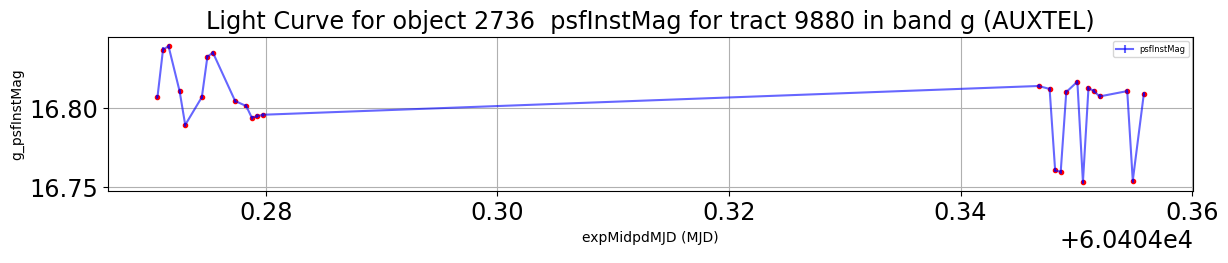

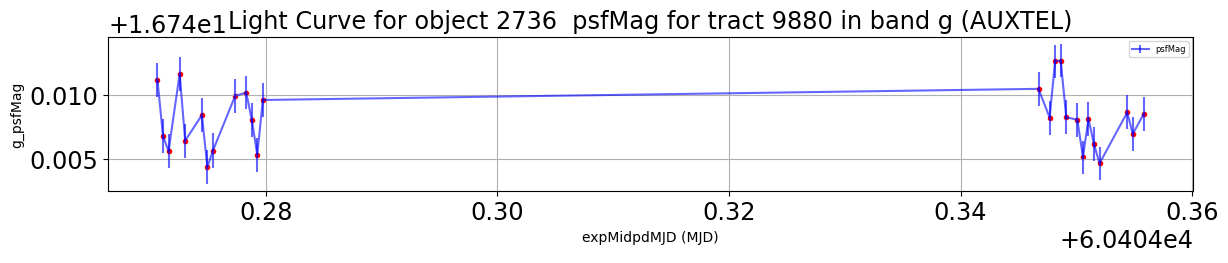

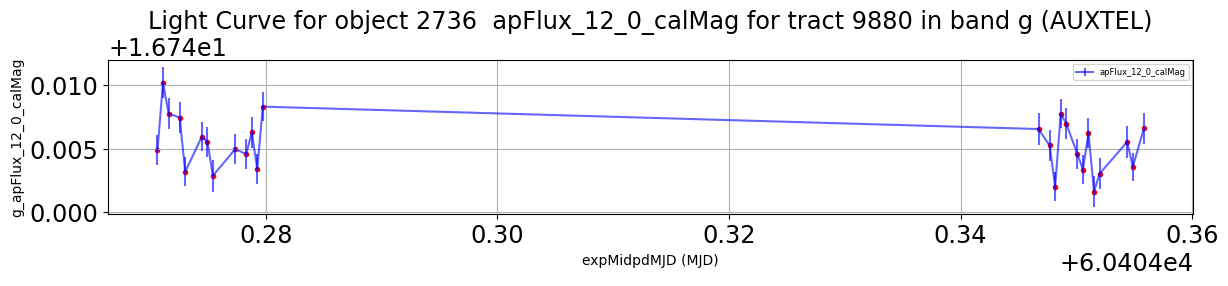

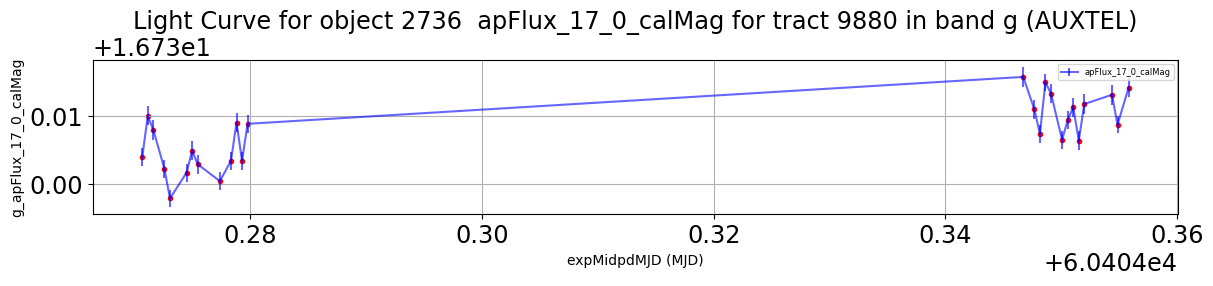

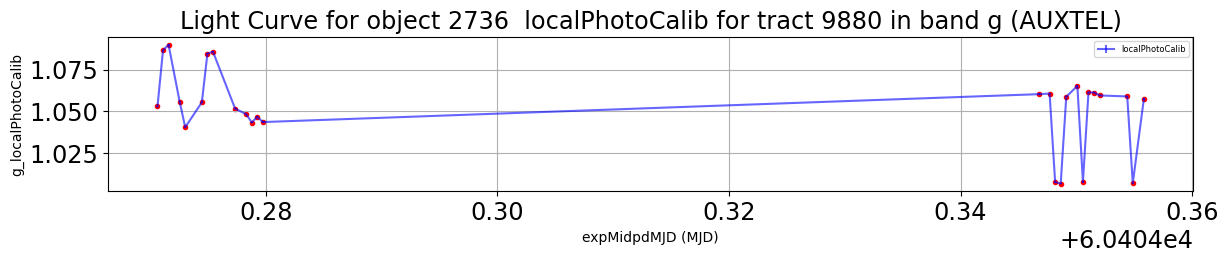

In [96]:
for magStr in ["psfInstMag", "psfMag","apFlux_12_0_calMag","apFlux_17_0_calMag","localPhotoCalib"]:  
    magerrStr = magStr+"Err"
    fig, ax = plt.subplots(1, 1, figsize=(14, 2))   
    xData = the_selected_object["expMidptMJD"]
    yData = the_selected_object[magStr]
    yDataErr = the_selected_object[magerrStr]
    yDataSorted = [y for _, y in sorted(zip(xData, yData))]
    yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
    xDataSorted = sorted(xData)
    
    ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", color="b",alpha=0.6, label=f"{magStr}".format(objInd))
    ax.scatter(xDataSorted, yDataSorted, s=9, c='r',alpha=1.0)
    ax.grid()

    
    ax.legend(fontsize=6, loc="upper right")
    ax.set_xlabel("{}{}".format("expMidpdMJD", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_{}".format(band, magStr), fontsize=10)
    title = f"Light Curve for object {index_sel}  {magStr} for tract {tract} in band {band} (AUXTEL)"
    ax.set_title(title)